In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/dataset_audio.zip
!unzip dataset_audio.zip

--2022-06-27 22:05:33--  https://perso.esiee.fr/~gueurett/LV_Research/dataset_audio.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156353364 (149M) [application/zip]
Saving to: ‘dataset_audio.zip’

dataset_audio.zip   100%[===================>] 149.11M  31.7MB/s    in 5.3s    

2022-06-27 22:05:39 (28.1 MB/s) - ‘dataset_audio.zip’ saved [156353364/156353364]

Archive:  dataset_audio.zip
   creating: dataset_audio/
  inflating: dataset_audio/I0014.wav  
  inflating: dataset_audio/I0044.wav  
  inflating: dataset_audio/I0094.wav  
  inflating: dataset_audio/I0114.wav  
  inflating: dataset_audio/I0164.wav  
  inflating: dataset_audio/I0194.wav  
  inflating: dataset_audio/I0264.wav  
  inflating: dataset_audio/I0304.wav  
  inflating: dataset_audio/I0354.wav  
  inflating: dataset_audio/I0374.wav  
  inflating: dataset_audio/I0384.wav  
  i

In [ ]:
# if wget desn't work (happens sometimes I believe it's because my school servers are blocking the access), import the dataset manualy and unzip on this block
!unzip dataset_audio.zip

Archive:  dataset_audio.zip
replace dataset_audio/I0014.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pydub import AudioSegment
from sklearn import preprocessing
from scipy.io.wavfile import read
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, initializers

---
---
# **Preprocessing**

In [ ]:
def delete_excess(data):
  return data[:length_audio]

def add_average(data):
  result = np.zeros(shape=(length_audio,))
  end = data.shape[0]
  mean = np.mean(data[end-25:])
  result[:end] = data
  result[end:] = mean
  return result

In [ ]:
directory = "./dataset_audio/"
file_name = "I0474.wav"
path = directory + file_name

print(path)

rate, data = read(path)

print("rate = ", rate)
print("data.shape = ", data.shape)

length = data.shape[0] / rate
print("length(s): ", length, "s")
length_audio = data.shape[0]
print("length of unique audio:", length_audio)
nb_channels = data.shape[1]
print("number of channels: ", nb_channels)

n_samples = 0
for file_name in os.listdir(directory):
  n_samples += 1
print("number of files:", n_samples)

dataset = np.zeros(shape=(n_samples, length_audio))

# creating the dataset and labels

labels = np.zeros(shape=(n_samples,))

# reshaping the data if not exactly 4s
for index, filename in enumerate(os.listdir(directory)):
  if filename[0] == 'I': labels[index] = 1    # indoor is 1, outdoor is 0
  path = directory + filename
  rate, data = read(path)
  data = np.mean(data,axis=1)
  dim = data.shape
  if dim != (length_audio, nb_channels):
    if dim[0] > length_audio:
      result = delete_excess(data)
    else:
      result = add_average(data)
    dataset[index] = result
  else:
    dataset[index] = data

dataset_norm = (dataset - np.mean(dataset)) / np.std(dataset)  # let's normalize

print("----------------------------------")
print("| dataset.shape: ", dataset.shape)
print("| labels.shape : ", labels.shape)
print("----------------------------------")

./dataset_audio/I0474.wav
rate =  44100
data.shape =  (176400, 2)
length(s):  4.0 s
length of unique audio: 176400
number of channels:  2
number of files: 200
----------------------------------
| dataset.shape:  (200, 176400)
| labels.shape :  (200,)
----------------------------------


(200, 176400)
(56, 176400)
(144, 176400)
---------------------------------


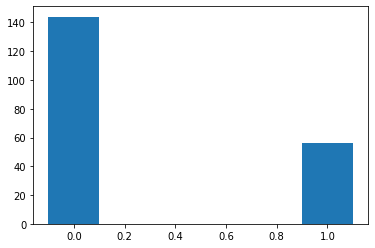

In [ ]:
# let's separate indor and outdoor data

args_indoor  = np.argwhere(labels==1)
args_outdoor = np.argwhere(labels==0)

data_indoor  = dataset[args_indoor].squeeze()
data_outdoor = dataset[args_outdoor].squeeze()

print(dataset.shape)
print(data_indoor.shape)
print(data_outdoor.shape)
print("---------------------------------")

plt.bar([0,1], [data_outdoor.shape[0], data_indoor.shape[0]], width=0.2);


---
---
# **Model Building**

In [ ]:
def get_generator():

  # label dimension (obvious)
  labels_dim = 1

  # latent space dimension
  latent_dim = 100

  # image dimension 28x28
  audio_dim = 176400

  init = initializers.RandomNormal(stddev=0.02)

  ######################################################################################

  # Generator network
  _input_generator = layers.Input(shape=(latent_dim,))

  # Output layer (before merging)
  _generator = (layers.Dense(100, activation='tanh'))(_input_generator)

  #######################################################################################

  # Labeling_generator
  _input_label_generator = layers.Input(shape=(labels_dim,), dtype='int32')

  # Output layer  (before merging)
  _label_generator = (layers.Dense(100, activation='tanh'))(_input_label_generator)

  ######################################################################################

  # Merging Layer
  generator = (layers.Multiply()([_generator, _label_generator]))
  generator = (layers.LeakyReLU(alpha=0.2))(generator)
  generator = (layers.BatchNormalization(momentum=0.8))(generator)

  # Hidden layer 1
  generator = (layers.Dense(200))(generator)
  generator = (layers.LeakyReLU(alpha=0.2))(generator)
  generator = (layers.BatchNormalization(momentum=0.8))(generator)

  # Hidden layer 1
  generator = (layers.Dense(500))(generator)
  generator = (layers.LeakyReLU(alpha=0.2))(generator)
  generator = (layers.BatchNormalization(momentum=0.8))(generator)
  
  # Hidden layer 1
  generator = (layers.Dense(1000))(generator)
  generator = (layers.LeakyReLU(alpha=0.2))(generator)
  generator = (layers.BatchNormalization(momentum=0.8))(generator)

  # Hidden layer 1
  generator = (layers.Dense(3000))(generator)
  generator = (layers.LeakyReLU(alpha=0.2))(generator)
  generator = (layers.BatchNormalization(momentum=0.8))(generator)

  # Final output layer (176400 neurons)
  generator = (layers.Dense(audio_dim, activation='tanh'))(generator)

  # Creating the model
  generator = tf.keras.Model(inputs=[_input_generator, _input_label_generator], outputs=generator)

  """
  # latent space
  z = layers.Input(shape=(latent_dim,))

  # Output image
  img = generator(input_generator)

  # Generator with condition input
  generator = tf.keras.models.Model([z, label], img)
  """

  return generator

In [ ]:
def generator_loss(fake_output):
  
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def get_discriminator():

  # label dimension (obvious)
  labels_dim = 1

  # prediction dimensions (class)
  results_dim = 1

  # image dimension 28x28
  audio_dim = 176400

  init = initializers.RandomNormal(stddev=0.02)

  ##############################################################################

  # Discriminator network
  _input_discriminator = layers.Input(shape=(audio_dim,))

  # Hidden layer 1
  #_discriminator = (layers.Dense(3000, kernel_initializer=init))(_input_discriminator)
  #_discriminator = (layers.LeakyReLU(alpha=0.2))(_discriminator)

  # Hidden layer 1
  #_discriminator = (layers.Dense(300, kernel_initializer=init))(_input_discriminator)
  #_discriminator = (layers.LeakyReLU(alpha=0.2))(_discriminator)

  # Output layer (before merging)

  _discriminator = (layers.Dense(100, activation='tanh'))(_input_discriminator)

  ##############################################################################

  # Labeling_discriminator
  _input_label_discriminator = layers.Input(shape=(labels_dim,), dtype='int32')

  # Hidden layer 1
  #_label_discriminator = (layers.Dense(128, kernel_initializer=init))(_input_label_discriminator)
  #_label_discriminator = (layers.LeakyReLU(alpha=0.2))(_label_discriminator)

  # Output layer  (before merging)
  _label_discriminator = (layers.Dense(100, activation='tanh'))(_input_label_discriminator)

  ##############################################################################

  # Merging Layer
  discriminator = (layers.Multiply()([_discriminator, _label_discriminator]))
  discriminator = (layers.LeakyReLU(alpha=0.2))(discriminator)

  # Hidden layer 1
  #discriminator = (layers.Dense(20))(discriminator)
  #discriminator = (layers.LeakyReLU(alpha=0.2))(discriminator)

  # Final output layer (1 neuron for classification)
  discriminator = (layers.Dense(results_dim, activation='sigmoid'))(discriminator)

  # Creating the model
  discriminator = tf.keras.Model(inputs=[_input_discriminator, _input_label_discriminator], outputs=discriminator)

  return discriminator

In [ ]:
def discriminator_loss(real_output, fake_output):

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

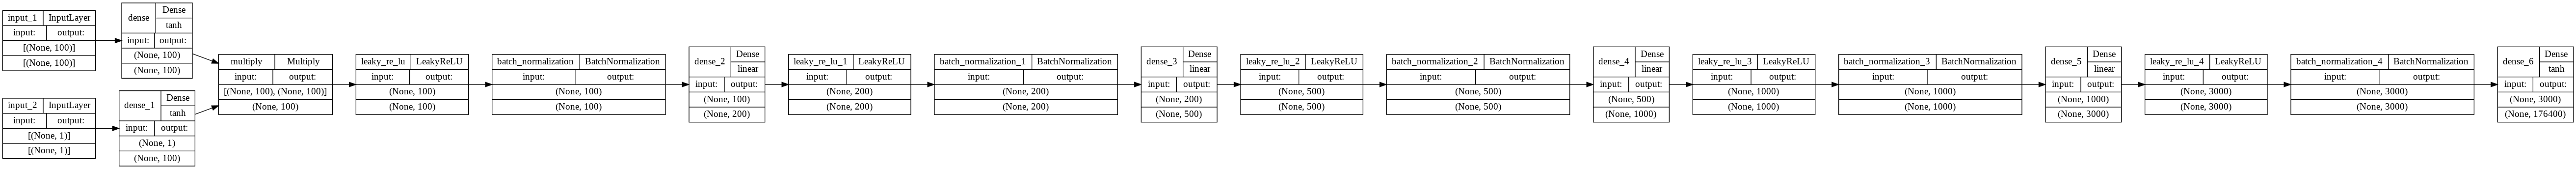

In [ ]:
# building the generator
generator = get_generator()

tf.keras.utils.plot_model(generator, to_file="generator.png", show_shapes=True, show_layer_activations=True, rankdir='LR')

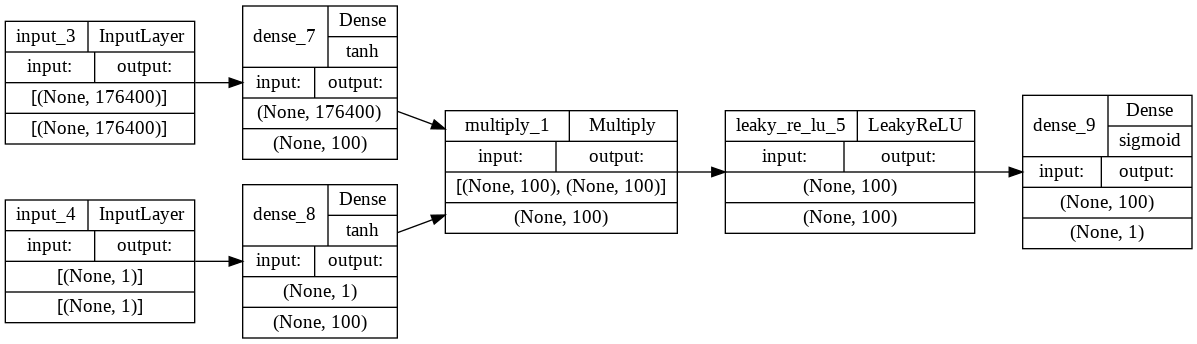

In [ ]:
# building the discriminator
discriminator = get_discriminator()

tf.keras.utils.plot_model(discriminator, to_file="discriminator.png", show_shapes=True, show_layer_activations=True, rankdir='LR')

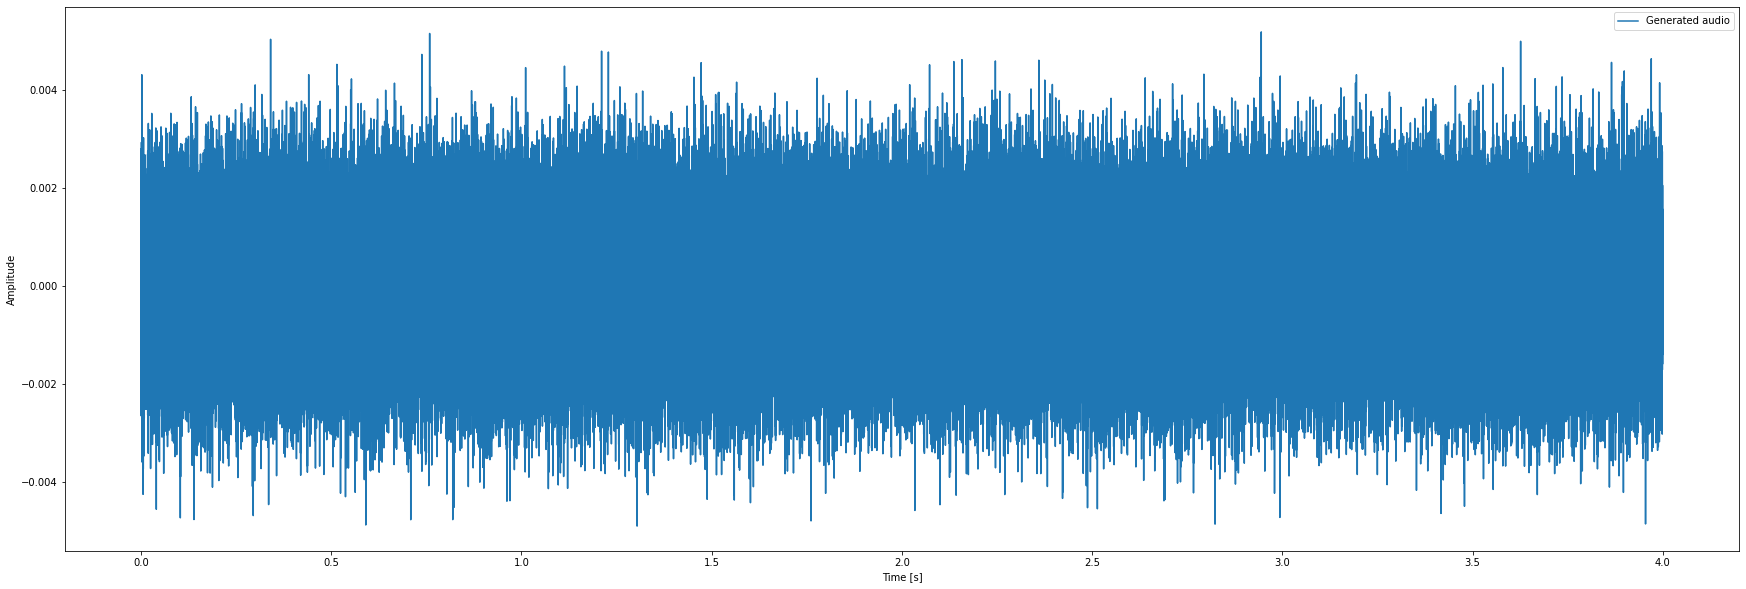

In [ ]:
# try the generator
latent_dim = 100
_time = np.linspace(0, 4, length_audio)

noise = tf.random.normal([1, latent_dim])
label = np.random.randint(0, 2, (1,))
seed = ([noise, label])

generated_audio = generator(seed, training=False)

fig = plt.figure(figsize=(30, 10))
plt.plot(_time, generated_audio[0, :], label="Generated audio")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# generator summary

generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          10100       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          200         ['input_2[0][0]']                
                                                                                              

In [ ]:
# try the discriminator
seed = ([generated_audio, label])

answer = discriminator(seed, training=False)
print("discriminator's aswer: ", answer)

discriminator's aswer:  tf.Tensor([[0.5000288]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 176400)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 100)          17640100    ['input_3[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 100)          200         ['input_4[0][0]']                
                                                                                            

---
---
# **Training functions and execution**

In [ ]:
def generate_loss_plot(history):
  
  fig = plt.figure(figsize=(20, 7))
  plt.plot(history[0,:], label="Generator Loss")
  plt.plot(history[1,:], label="Discriminator Loss")
  plt.legend()
  plt.xlabel("Batches")
  plt.ylabel("Loss")
  plt.show()

In [ ]:
def generate_plot(generator, epoch):

  n_classes = 2

  time = np.linspace(0., length, data.shape[0])
  noise = tf.random.normal([1, LATENT_DIM])
  label_outdoor = np.zeros(shape=(1,))
  label_indoor  = np.ones(shape=(1,))

  # first class
  seed = ([noise, label_outdoor])
  generated_audio = generator(seed, training=False)

  fig = plt.figure(figsize=(10, 10))
  plt.subplot(2,1,1)
  plt.plot(time, generated_audio[0, :], label="Generated Audio Outdoor");
  plt.legend()
  plt.xlabel("Time [s]")
  plt.ylabel("Amplitude")
  plt.show()

  # second class
  seed = ([noise, label_indoor])
  generated_audio = generator(seed, training=False)

  fig = plt.figure(figsize=(10, 10))
  plt.subplot(2,1,2)
  plt.plot(time, generated_audio[0, :], label="Generated Audio Indoor");
  plt.legend()
  plt.xlabel("Time [s]")
  plt.ylabel("Amplitude")
  plt.show()

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

In [ ]:
@tf.function
def train_step(audios, labels):

    noises = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    labels_fake = np.random.randint(2, size=(BATCH_SIZE,))
    gen_seed=([noises, labels_fake])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_audios = generator(gen_seed, training=True)

      real_output = discriminator( ([audios           , labels])        , training=True)
      fake_output = discriminator( ([generated_audios , labels_fake])   , training=True)

      gen_loss  = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      losses = (gen_loss, disc_loss)

    gradients_of_generator      = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator  = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return losses

In [ ]:
def train(batched_data, epochs, epochs_plot=False, history_plot=False):

  history = np.empty(shape=(2,0))

  for epoch in range(epochs):
    start = time.time()

    for batched_audios, batched_labels in batched_data:
      losses = train_step(batched_audios, batched_labels)
      losses = np.array([losses[0].numpy(), losses[1].numpy()]).reshape((2,1))
      history = np.append(history, losses, axis=1)

    #display.clear_output(wait=True)
    if epochs_plot: generate_plot(generator, epoch + 1)
    if history_plot: generate_loss_plot(history)

    if (epoch + 1) % 15 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)
      if epochs_plot: generate_plot(generator, epoch + 1)
      generate_loss_plot(history)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #display.clear_output(wait=True)
  generate_plot(generator, epochs)
  generate_loss_plot(history)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

generator_optimizer       = Adam(8e-5)
discriminator_optimizer   = Adam(2e-5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Time for epoch 1 is 5.760815858840942 sec
Time for epoch 2 is 2.7171971797943115 sec
Time for epoch 3 is 2.6399123668670654 sec
Time for epoch 4 is 2.6499428749084473 sec
Time for epoch 5 is 2.654425859451294 sec
Time for epoch 6 is 2.6470861434936523 sec
Time for epoch 7 is 2.6484220027923584 sec
Time for epoch 8 is 2.642698287963867 sec
Time for epoch 9 is 2.656135320663452 sec
Time for epoch 10 is 2.65151309967041 sec
Time for epoch 11 is 2.6624560356140137 sec
Time for epoch 12 is 2.6495490074157715 sec
Time for epoch 13 is 2.6367549896240234 sec
Time for epoch 14 is 2.651719570159912 sec


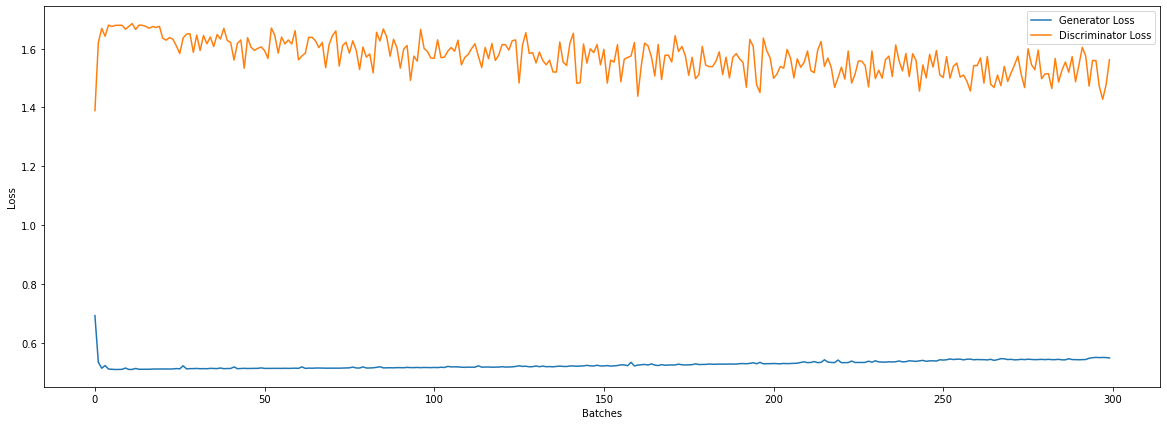

Time for epoch 15 is 2.8231821060180664 sec
Time for epoch 16 is 2.64304780960083 sec
Time for epoch 17 is 2.642256259918213 sec
Time for epoch 18 is 2.651477336883545 sec
Time for epoch 19 is 2.6350040435791016 sec
Time for epoch 20 is 2.6472015380859375 sec
Time for epoch 21 is 2.640873908996582 sec
Time for epoch 22 is 2.6467416286468506 sec
Time for epoch 23 is 2.6440670490264893 sec
Time for epoch 24 is 2.646885633468628 sec
Time for epoch 25 is 2.660942792892456 sec
Time for epoch 26 is 2.643211841583252 sec
Time for epoch 27 is 2.651944875717163 sec
Time for epoch 28 is 2.651317596435547 sec
Time for epoch 29 is 2.651064157485962 sec


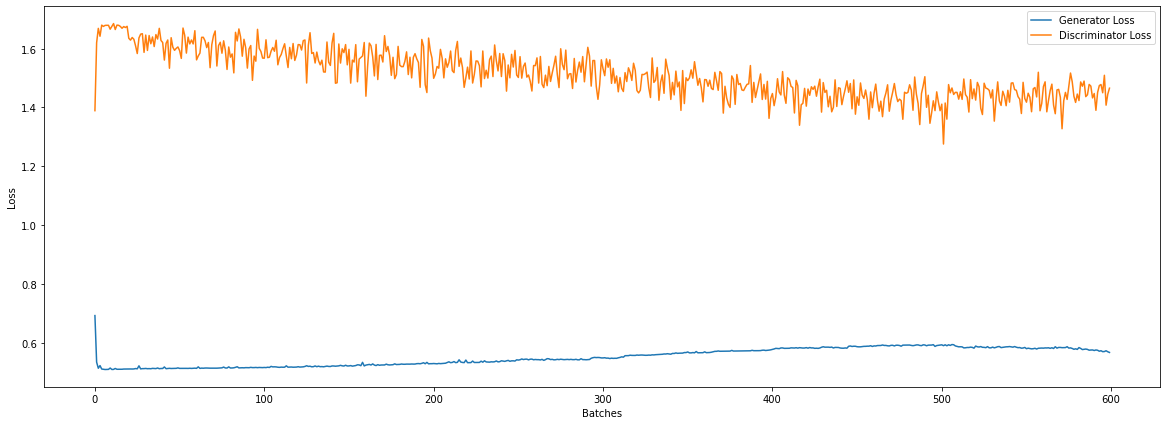

Time for epoch 30 is 2.8323276042938232 sec
Time for epoch 31 is 2.652604103088379 sec
Time for epoch 32 is 2.6571452617645264 sec
Time for epoch 33 is 2.6646363735198975 sec
Time for epoch 34 is 2.662454128265381 sec
Time for epoch 35 is 2.6888575553894043 sec
Time for epoch 36 is 2.6642019748687744 sec
Time for epoch 37 is 2.66265606880188 sec
Time for epoch 38 is 2.6735193729400635 sec
Time for epoch 39 is 2.6700191497802734 sec
Time for epoch 40 is 2.6707918643951416 sec
Time for epoch 41 is 2.6751163005828857 sec
Time for epoch 42 is 2.674044132232666 sec
Time for epoch 43 is 2.671900510787964 sec
Time for epoch 44 is 2.6706531047821045 sec


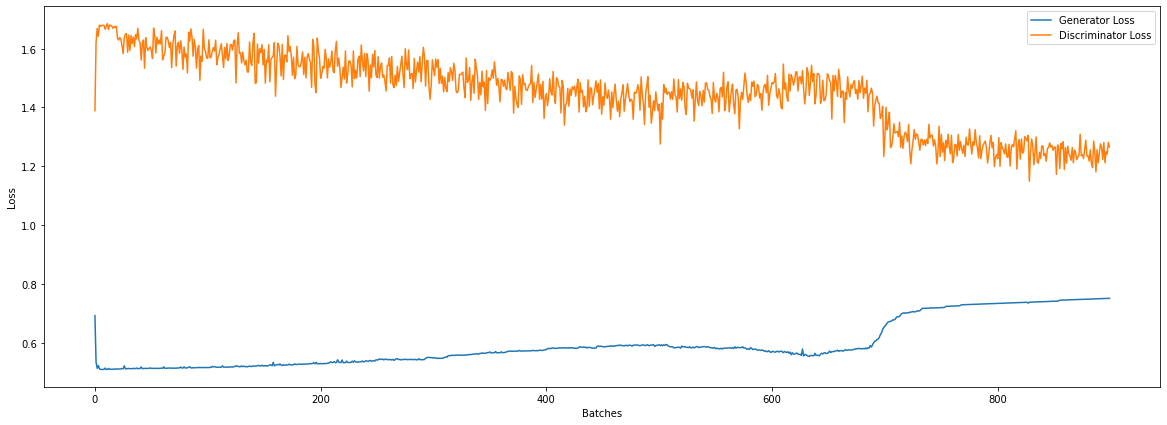

Time for epoch 45 is 3.002399206161499 sec
Time for epoch 46 is 2.6745498180389404 sec
Time for epoch 47 is 2.6833720207214355 sec
Time for epoch 48 is 2.6786980628967285 sec
Time for epoch 49 is 2.6901943683624268 sec
Time for epoch 50 is 2.6740849018096924 sec
Time for epoch 51 is 2.696981906890869 sec
Time for epoch 52 is 2.7083277702331543 sec
Time for epoch 53 is 2.6955273151397705 sec
Time for epoch 54 is 2.6938374042510986 sec
Time for epoch 55 is 2.695065498352051 sec
Time for epoch 56 is 2.7086076736450195 sec
Time for epoch 57 is 2.6811916828155518 sec
Time for epoch 58 is 2.6828033924102783 sec
Time for epoch 59 is 2.674870014190674 sec


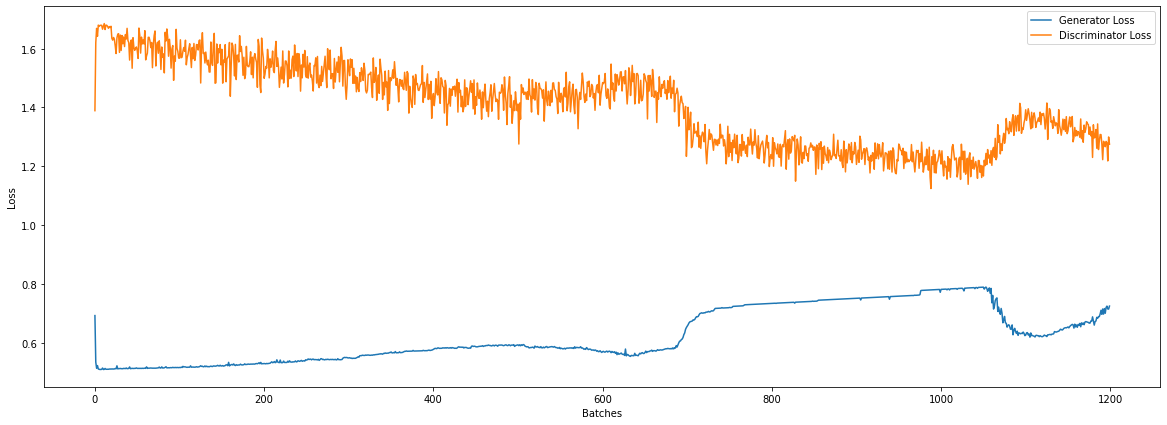

Time for epoch 60 is 2.8759827613830566 sec
Time for epoch 61 is 2.675137996673584 sec
Time for epoch 62 is 2.686404228210449 sec
Time for epoch 63 is 2.6765897274017334 sec
Time for epoch 64 is 2.667245864868164 sec
Time for epoch 65 is 2.687251567840576 sec
Time for epoch 66 is 2.677251100540161 sec
Time for epoch 67 is 2.681480646133423 sec
Time for epoch 68 is 2.6811976432800293 sec
Time for epoch 69 is 2.689267635345459 sec
Time for epoch 70 is 2.6877176761627197 sec
Time for epoch 71 is 2.685434579849243 sec
Time for epoch 72 is 2.6766695976257324 sec
Time for epoch 73 is 2.6783323287963867 sec
Time for epoch 74 is 2.6776351928710938 sec


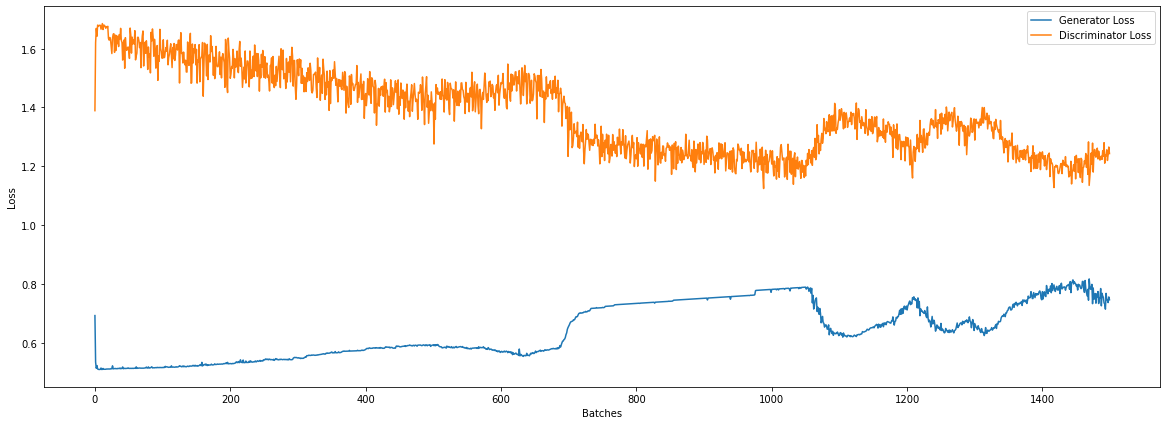

Time for epoch 75 is 2.8554975986480713 sec
Time for epoch 76 is 2.680922508239746 sec
Time for epoch 77 is 2.679673910140991 sec
Time for epoch 78 is 2.6775336265563965 sec
Time for epoch 79 is 2.681952476501465 sec
Time for epoch 80 is 2.6799721717834473 sec
Time for epoch 81 is 2.694082021713257 sec
Time for epoch 82 is 2.684859037399292 sec
Time for epoch 83 is 2.688852071762085 sec
Time for epoch 84 is 2.6923468112945557 sec
Time for epoch 85 is 2.6823012828826904 sec
Time for epoch 86 is 2.6865155696868896 sec
Time for epoch 87 is 2.6848199367523193 sec
Time for epoch 88 is 2.6818301677703857 sec
Time for epoch 89 is 2.685375452041626 sec


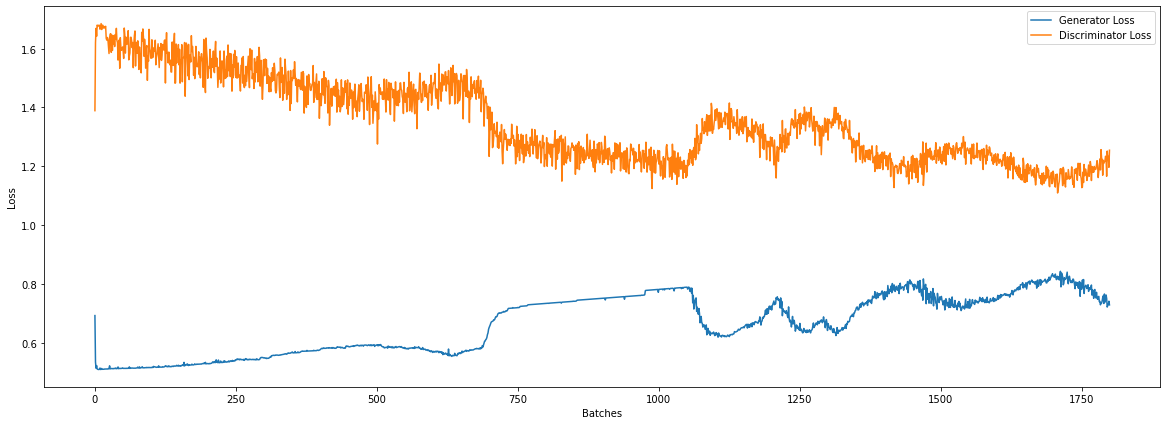

Time for epoch 90 is 2.876066207885742 sec
Time for epoch 91 is 2.68660306930542 sec
Time for epoch 92 is 2.6856119632720947 sec
Time for epoch 93 is 2.6797943115234375 sec
Time for epoch 94 is 2.6911239624023438 sec
Time for epoch 95 is 2.680807590484619 sec
Time for epoch 96 is 2.681915283203125 sec
Time for epoch 97 is 2.685868263244629 sec
Time for epoch 98 is 2.6852452754974365 sec
Time for epoch 99 is 2.6852211952209473 sec
Time for epoch 100 is 2.679800271987915 sec
Time for epoch 101 is 2.6869685649871826 sec
Time for epoch 102 is 2.681398630142212 sec
Time for epoch 103 is 2.69128155708313 sec
Time for epoch 104 is 2.6761691570281982 sec


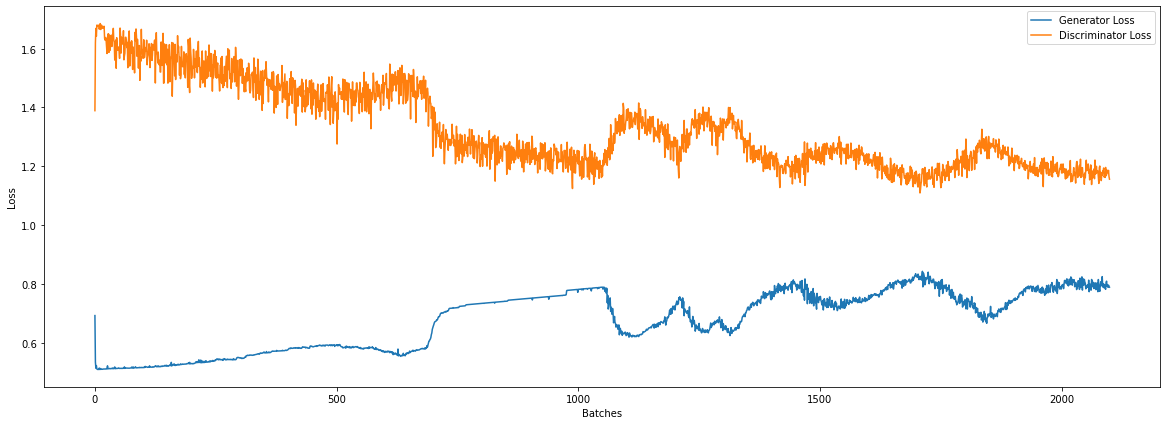

Time for epoch 105 is 2.8627142906188965 sec
Time for epoch 106 is 2.6867384910583496 sec
Time for epoch 107 is 2.671077013015747 sec
Time for epoch 108 is 2.6742026805877686 sec
Time for epoch 109 is 2.687364339828491 sec
Time for epoch 110 is 2.6757378578186035 sec
Time for epoch 111 is 2.6794283390045166 sec
Time for epoch 112 is 2.67992901802063 sec
Time for epoch 113 is 5.171198129653931 sec
Time for epoch 114 is 2.6956183910369873 sec
Time for epoch 115 is 2.6781973838806152 sec
Time for epoch 116 is 2.6782946586608887 sec
Time for epoch 117 is 2.6886160373687744 sec
Time for epoch 118 is 2.6816365718841553 sec
Time for epoch 119 is 2.687629222869873 sec


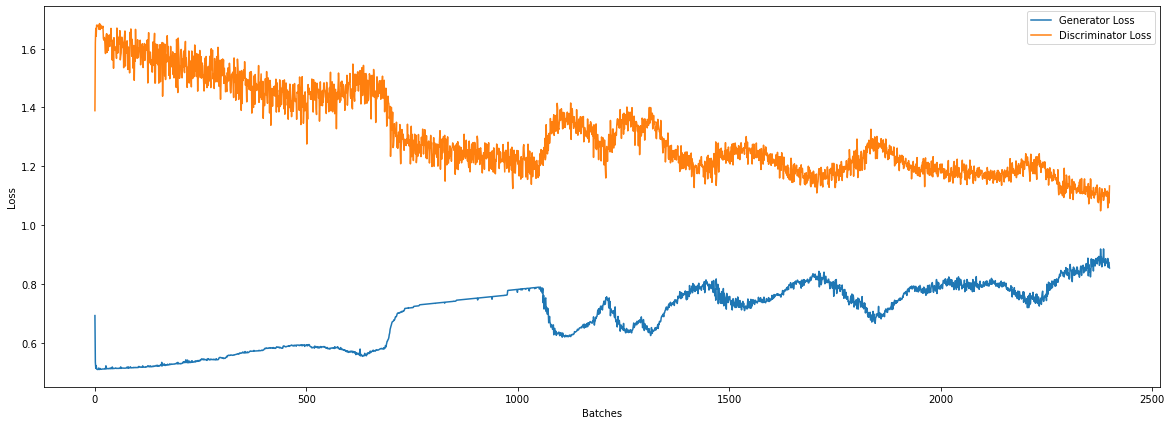

Time for epoch 120 is 2.879962682723999 sec
Time for epoch 121 is 2.695065498352051 sec
Time for epoch 122 is 2.6854116916656494 sec
Time for epoch 123 is 2.6883816719055176 sec
Time for epoch 124 is 2.6939728260040283 sec
Time for epoch 125 is 2.692373514175415 sec
Time for epoch 126 is 2.691298723220825 sec
Time for epoch 127 is 2.6869378089904785 sec
Time for epoch 128 is 2.68754506111145 sec
Time for epoch 129 is 2.684783458709717 sec
Time for epoch 130 is 2.688345432281494 sec
Time for epoch 131 is 2.6858928203582764 sec
Time for epoch 132 is 2.695443630218506 sec
Time for epoch 133 is 2.69779109954834 sec
Time for epoch 134 is 2.680190086364746 sec


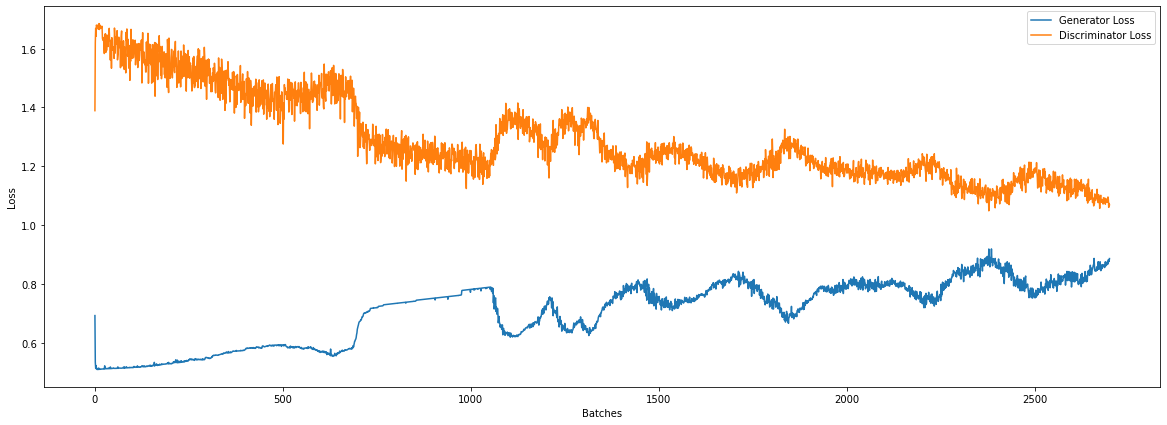

Time for epoch 135 is 2.874936819076538 sec
Time for epoch 136 is 2.699079990386963 sec
Time for epoch 137 is 2.689671516418457 sec
Time for epoch 138 is 2.6871492862701416 sec
Time for epoch 139 is 2.6808762550354004 sec
Time for epoch 140 is 2.686619997024536 sec
Time for epoch 141 is 2.694650650024414 sec
Time for epoch 142 is 2.6853625774383545 sec
Time for epoch 143 is 2.6899240016937256 sec
Time for epoch 144 is 2.698155164718628 sec
Time for epoch 145 is 2.6938939094543457 sec
Time for epoch 146 is 2.6818807125091553 sec
Time for epoch 147 is 2.6907997131347656 sec
Time for epoch 148 is 2.6898868083953857 sec
Time for epoch 149 is 2.6839258670806885 sec


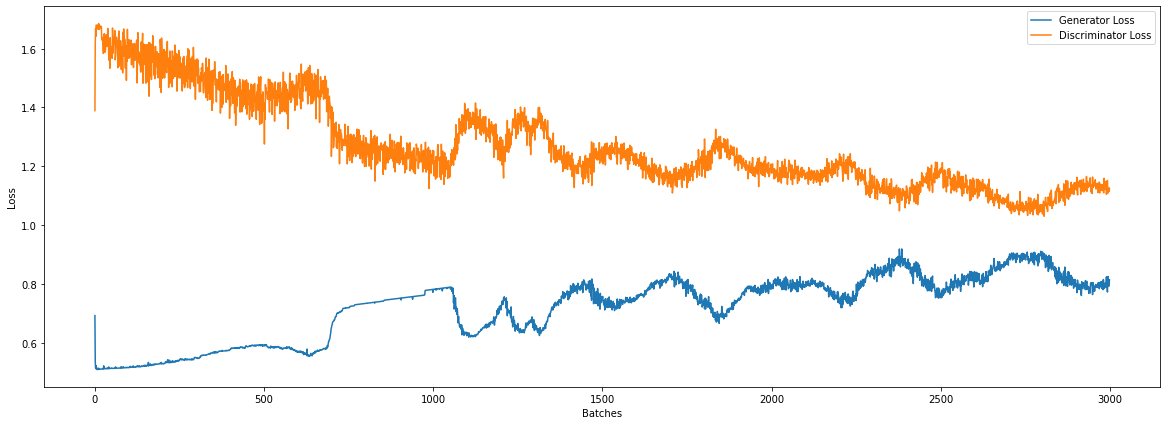

Time for epoch 150 is 2.8711047172546387 sec
Time for epoch 151 is 2.6835482120513916 sec
Time for epoch 152 is 2.693938732147217 sec
Time for epoch 153 is 2.6900434494018555 sec
Time for epoch 154 is 2.681889057159424 sec
Time for epoch 155 is 2.686814069747925 sec
Time for epoch 156 is 2.6811745166778564 sec
Time for epoch 157 is 5.168761730194092 sec
Time for epoch 158 is 2.711881399154663 sec
Time for epoch 159 is 2.6833086013793945 sec
Time for epoch 160 is 2.683121919631958 sec
Time for epoch 161 is 2.682786226272583 sec
Time for epoch 162 is 2.677003860473633 sec
Time for epoch 163 is 2.692298412322998 sec
Time for epoch 164 is 2.6945528984069824 sec


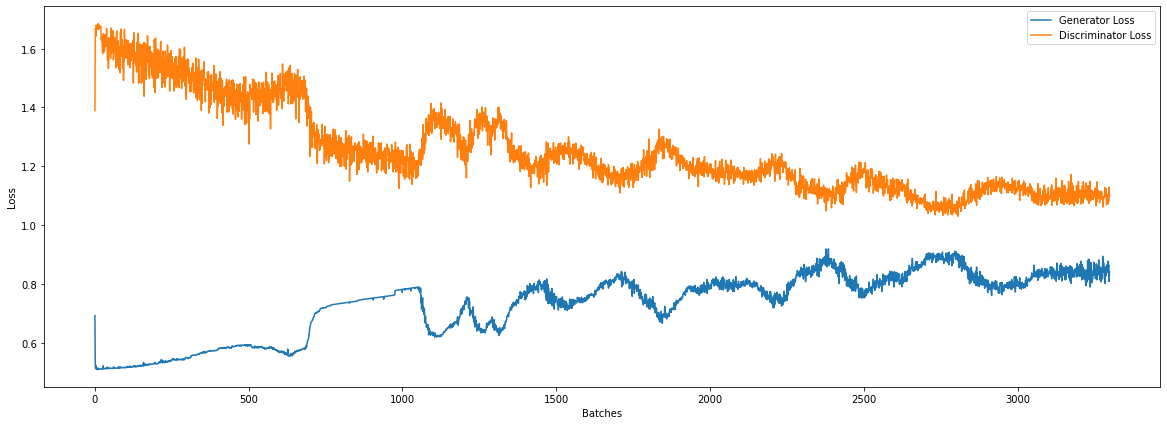

Time for epoch 165 is 2.8838353157043457 sec
Time for epoch 166 is 2.693873405456543 sec
Time for epoch 167 is 2.6881227493286133 sec
Time for epoch 168 is 2.6932284832000732 sec
Time for epoch 169 is 2.6850473880767822 sec
Time for epoch 170 is 2.691648006439209 sec
Time for epoch 171 is 2.687290906906128 sec
Time for epoch 172 is 2.6927859783172607 sec
Time for epoch 173 is 2.6890780925750732 sec
Time for epoch 174 is 2.6899383068084717 sec
Time for epoch 175 is 2.6865432262420654 sec
Time for epoch 176 is 2.686335325241089 sec
Time for epoch 177 is 5.167716026306152 sec
Time for epoch 178 is 2.695159673690796 sec
Time for epoch 179 is 2.6905927658081055 sec


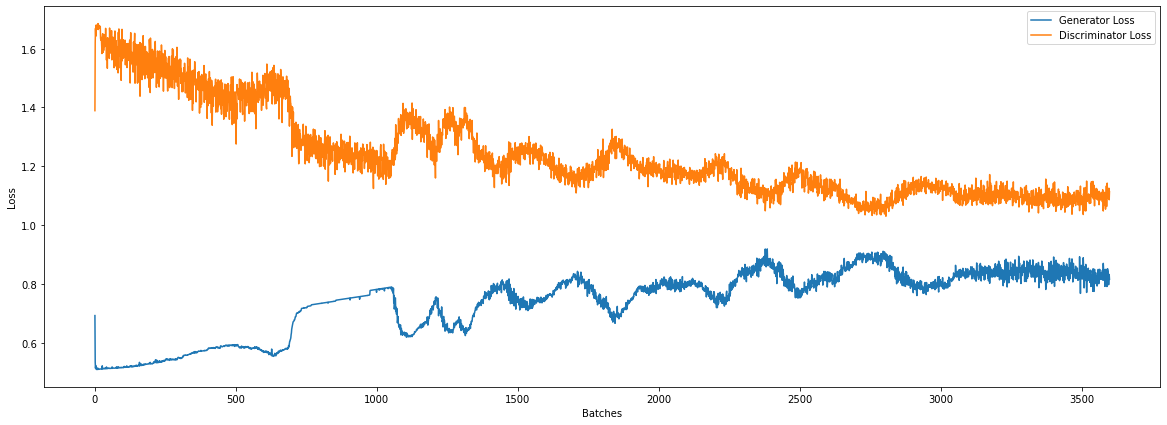

Time for epoch 180 is 2.877838134765625 sec
Time for epoch 181 is 2.6943225860595703 sec
Time for epoch 182 is 2.682807207107544 sec
Time for epoch 183 is 2.6819348335266113 sec
Time for epoch 184 is 2.680516242980957 sec
Time for epoch 185 is 2.680954933166504 sec
Time for epoch 186 is 2.6859545707702637 sec
Time for epoch 187 is 2.6923000812530518 sec
Time for epoch 188 is 2.6888084411621094 sec
Time for epoch 189 is 2.6890649795532227 sec
Time for epoch 190 is 2.6843912601470947 sec
Time for epoch 191 is 2.7058095932006836 sec
Time for epoch 192 is 2.689669132232666 sec
Time for epoch 193 is 2.680593729019165 sec
Time for epoch 194 is 2.68624210357666 sec


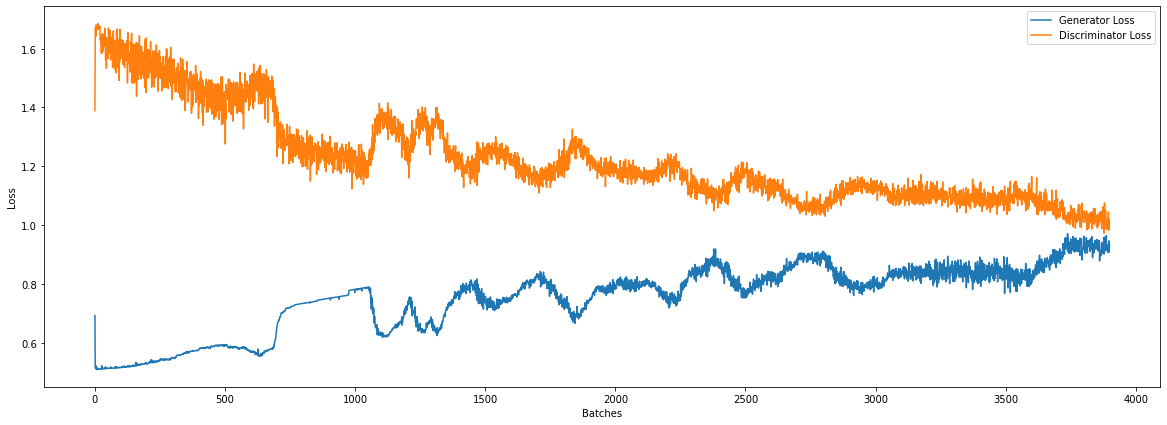

Time for epoch 195 is 2.8860578536987305 sec
Time for epoch 196 is 2.703796863555908 sec
Time for epoch 197 is 2.6815402507781982 sec
Time for epoch 198 is 2.700984001159668 sec
Time for epoch 199 is 2.694399833679199 sec
Time for epoch 200 is 2.6847527027130127 sec
Time for epoch 201 is 2.6907799243927 sec
Time for epoch 202 is 2.684779167175293 sec
Time for epoch 203 is 2.6877005100250244 sec
Time for epoch 204 is 2.679373264312744 sec
Time for epoch 205 is 2.692561626434326 sec
Time for epoch 206 is 2.6682472229003906 sec
Time for epoch 207 is 2.6819510459899902 sec
Time for epoch 208 is 2.69356107711792 sec
Time for epoch 209 is 2.6967520713806152 sec


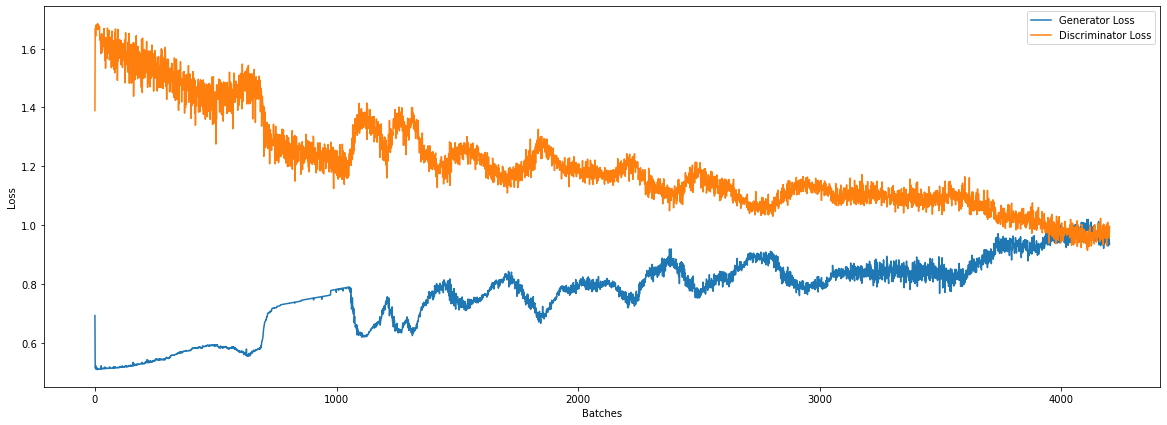

Time for epoch 210 is 2.8705015182495117 sec
Time for epoch 211 is 2.6897573471069336 sec
Time for epoch 212 is 2.671175241470337 sec
Time for epoch 213 is 2.6862919330596924 sec
Time for epoch 214 is 2.6954305171966553 sec
Time for epoch 215 is 2.6855859756469727 sec
Time for epoch 216 is 2.6891837120056152 sec
Time for epoch 217 is 2.6956193447113037 sec
Time for epoch 218 is 2.6842057704925537 sec
Time for epoch 219 is 2.689365863800049 sec
Time for epoch 220 is 2.6963608264923096 sec
Time for epoch 221 is 2.6887731552124023 sec
Time for epoch 222 is 2.6923258304595947 sec
Time for epoch 223 is 2.687889575958252 sec
Time for epoch 224 is 2.6773130893707275 sec


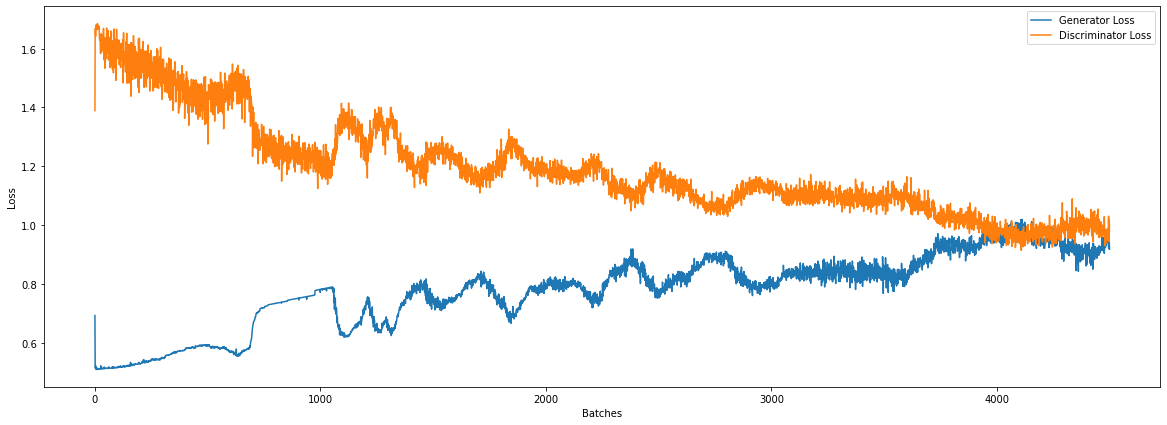

Time for epoch 225 is 2.8816864490509033 sec
Time for epoch 226 is 2.698005437850952 sec
Time for epoch 227 is 2.6875100135803223 sec
Time for epoch 228 is 2.694234609603882 sec
Time for epoch 229 is 2.695744037628174 sec
Time for epoch 230 is 2.6897354125976562 sec
Time for epoch 231 is 2.687544345855713 sec
Time for epoch 232 is 2.6916074752807617 sec
Time for epoch 233 is 2.69889235496521 sec
Time for epoch 234 is 2.6879637241363525 sec
Time for epoch 235 is 2.681875228881836 sec
Time for epoch 236 is 2.693213701248169 sec
Time for epoch 237 is 2.696033477783203 sec
Time for epoch 238 is 2.6937782764434814 sec
Time for epoch 239 is 2.6902968883514404 sec


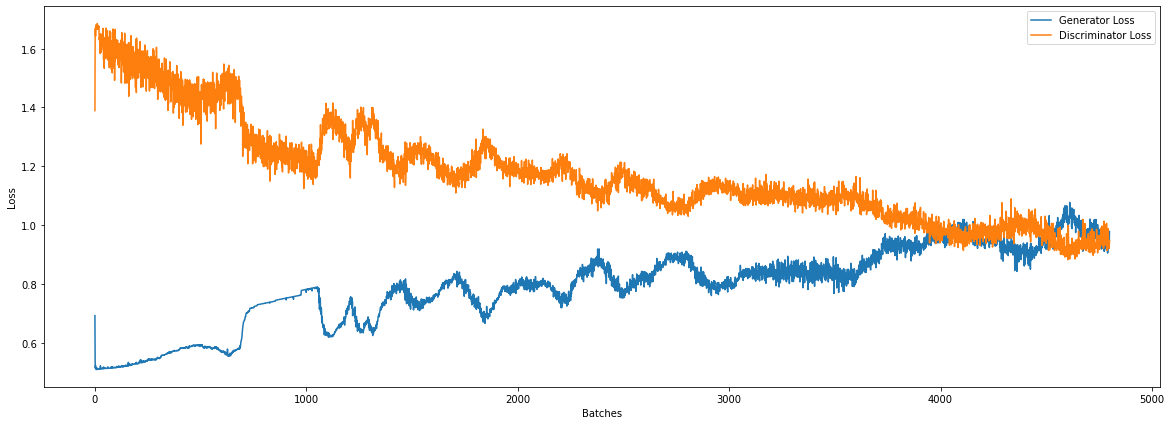

Time for epoch 240 is 2.8916990756988525 sec
Time for epoch 241 is 2.700718641281128 sec
Time for epoch 242 is 2.6878936290740967 sec
Time for epoch 243 is 2.696636438369751 sec
Time for epoch 244 is 2.6919479370117188 sec
Time for epoch 245 is 2.6822304725646973 sec
Time for epoch 246 is 2.698925256729126 sec
Time for epoch 247 is 2.6920530796051025 sec
Time for epoch 248 is 2.7042808532714844 sec
Time for epoch 249 is 2.69380259513855 sec
Time for epoch 250 is 2.6965017318725586 sec
Time for epoch 251 is 2.6950645446777344 sec
Time for epoch 252 is 2.683379888534546 sec
Time for epoch 253 is 2.6865196228027344 sec
Time for epoch 254 is 2.694047212600708 sec


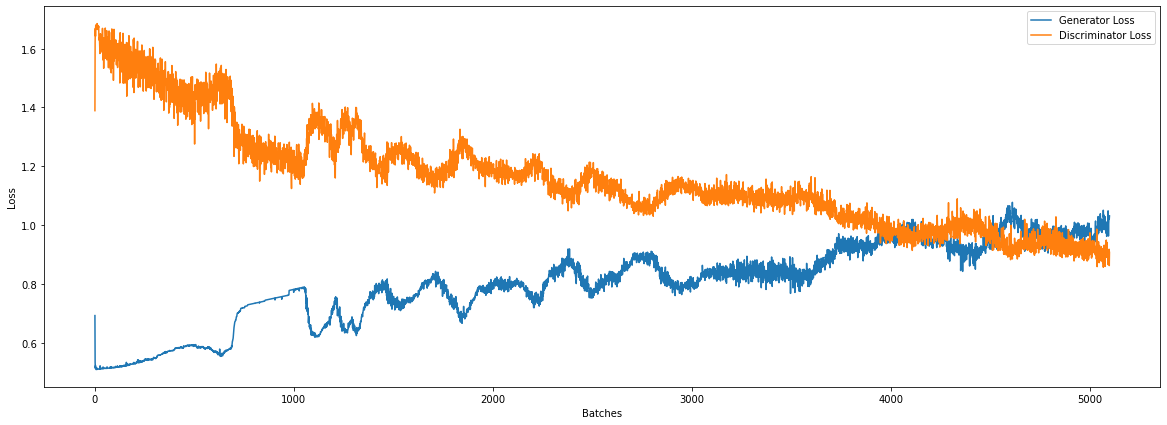

Time for epoch 255 is 2.8684260845184326 sec
Time for epoch 256 is 2.6916418075561523 sec
Time for epoch 257 is 2.677732229232788 sec
Time for epoch 258 is 2.677217483520508 sec
Time for epoch 259 is 2.6945207118988037 sec
Time for epoch 260 is 2.68992280960083 sec
Time for epoch 261 is 2.6889195442199707 sec
Time for epoch 262 is 2.683206081390381 sec
Time for epoch 263 is 2.690622329711914 sec
Time for epoch 264 is 2.6857142448425293 sec
Time for epoch 265 is 5.180753469467163 sec
Time for epoch 266 is 2.7012946605682373 sec
Time for epoch 267 is 2.6776509284973145 sec
Time for epoch 268 is 2.698996067047119 sec
Time for epoch 269 is 2.701364755630493 sec


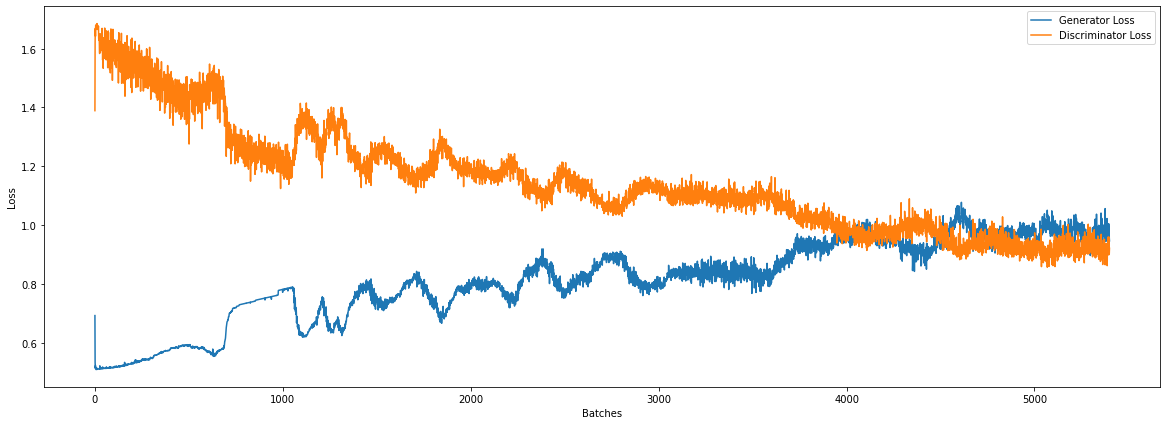

Time for epoch 270 is 2.880402088165283 sec
Time for epoch 271 is 2.689851760864258 sec
Time for epoch 272 is 2.685311794281006 sec
Time for epoch 273 is 2.6865177154541016 sec
Time for epoch 274 is 2.690700054168701 sec
Time for epoch 275 is 5.182717561721802 sec
Time for epoch 276 is 2.721675395965576 sec
Time for epoch 277 is 2.6936001777648926 sec
Time for epoch 278 is 2.679853677749634 sec
Time for epoch 279 is 2.681750535964966 sec
Time for epoch 280 is 2.686210870742798 sec
Time for epoch 281 is 2.6948494911193848 sec
Time for epoch 282 is 2.701061725616455 sec
Time for epoch 283 is 2.6905102729797363 sec
Time for epoch 284 is 2.704385280609131 sec


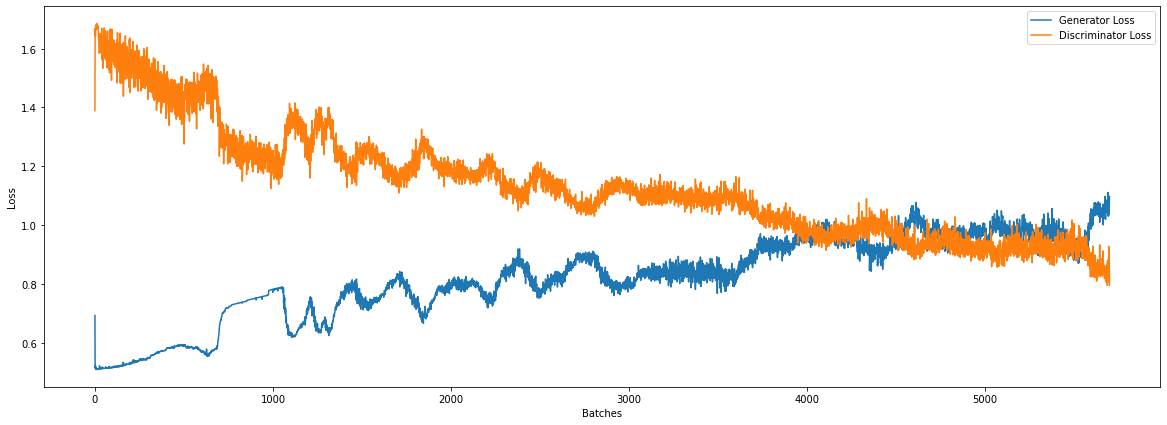

Time for epoch 285 is 2.8914289474487305 sec
Time for epoch 286 is 2.6867313385009766 sec
Time for epoch 287 is 2.6919713020324707 sec
Time for epoch 288 is 2.6754069328308105 sec
Time for epoch 289 is 2.6813790798187256 sec
Time for epoch 290 is 2.702645778656006 sec
Time for epoch 291 is 2.6954104900360107 sec
Time for epoch 292 is 2.6955413818359375 sec
Time for epoch 293 is 2.6788558959960938 sec
Time for epoch 294 is 5.170482397079468 sec
Time for epoch 295 is 2.6996355056762695 sec
Time for epoch 296 is 2.6840410232543945 sec
Time for epoch 297 is 2.6884145736694336 sec
Time for epoch 298 is 2.6962451934814453 sec
Time for epoch 299 is 2.689398765563965 sec


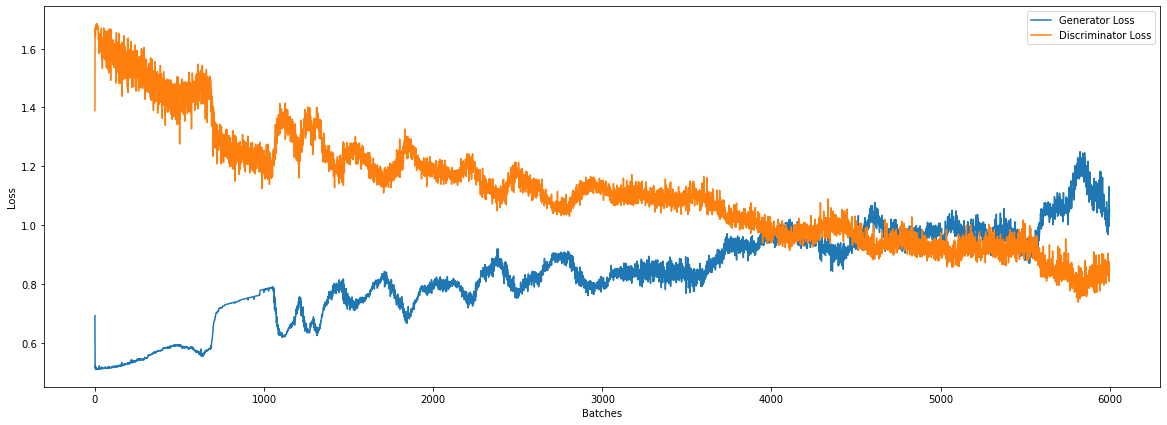

Time for epoch 300 is 2.881080150604248 sec
Time for epoch 301 is 2.6984305381774902 sec
Time for epoch 302 is 2.6899006366729736 sec
Time for epoch 303 is 2.6985228061676025 sec
Time for epoch 304 is 2.7061500549316406 sec
Time for epoch 305 is 2.6923749446868896 sec
Time for epoch 306 is 2.69687819480896 sec
Time for epoch 307 is 2.71628999710083 sec
Time for epoch 308 is 2.6913065910339355 sec
Time for epoch 309 is 2.6907739639282227 sec
Time for epoch 310 is 2.683810234069824 sec
Time for epoch 311 is 2.687282085418701 sec
Time for epoch 312 is 2.6878368854522705 sec
Time for epoch 313 is 2.6896514892578125 sec
Time for epoch 314 is 2.6809232234954834 sec


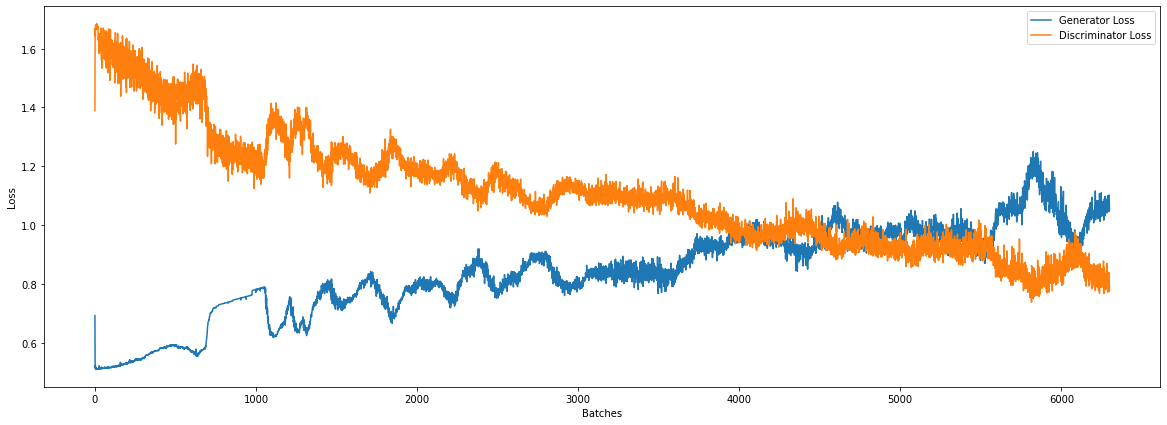

Time for epoch 315 is 2.902291774749756 sec
Time for epoch 316 is 2.692302942276001 sec
Time for epoch 317 is 2.6850428581237793 sec
Time for epoch 318 is 2.6964685916900635 sec
Time for epoch 319 is 2.691833972930908 sec
Time for epoch 320 is 2.6772804260253906 sec
Time for epoch 321 is 2.6856071949005127 sec
Time for epoch 322 is 2.6916913986206055 sec
Time for epoch 323 is 2.684889554977417 sec
Time for epoch 324 is 2.690701961517334 sec
Time for epoch 325 is 2.6953601837158203 sec
Time for epoch 326 is 2.687889337539673 sec
Time for epoch 327 is 2.6984291076660156 sec
Time for epoch 328 is 2.6821887493133545 sec
Time for epoch 329 is 2.698301076889038 sec


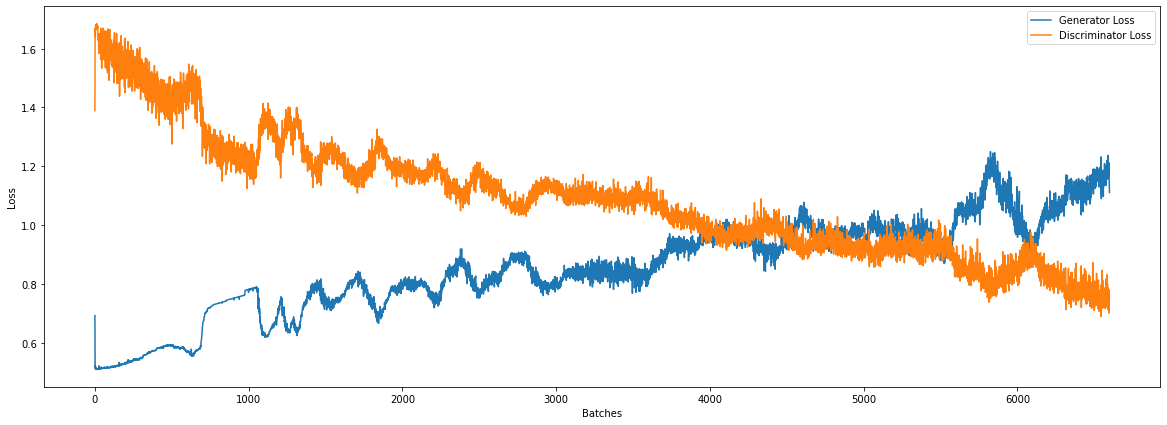

Time for epoch 330 is 2.889997720718384 sec
Time for epoch 331 is 2.689441204071045 sec
Time for epoch 332 is 2.684282064437866 sec
Time for epoch 333 is 2.6904897689819336 sec
Time for epoch 334 is 2.688375473022461 sec
Time for epoch 335 is 2.6868743896484375 sec
Time for epoch 336 is 2.6884539127349854 sec
Time for epoch 337 is 2.687925338745117 sec
Time for epoch 338 is 2.6919918060302734 sec
Time for epoch 339 is 2.7262179851531982 sec
Time for epoch 340 is 2.685300588607788 sec
Time for epoch 341 is 2.6904592514038086 sec
Time for epoch 342 is 2.6772468090057373 sec
Time for epoch 343 is 2.706930160522461 sec
Time for epoch 344 is 2.700202226638794 sec


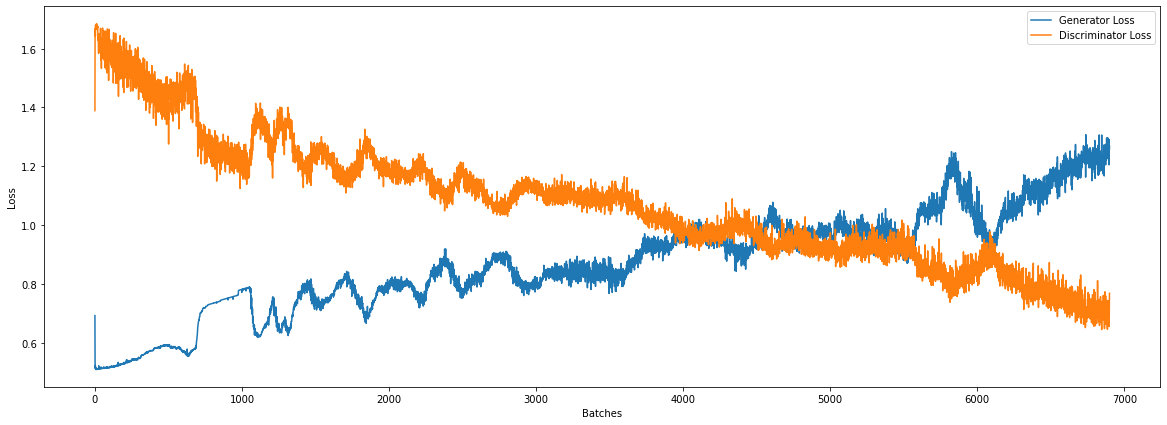

Time for epoch 345 is 2.9027099609375 sec
Time for epoch 346 is 2.695888042449951 sec
Time for epoch 347 is 2.695807456970215 sec
Time for epoch 348 is 2.687044143676758 sec
Time for epoch 349 is 2.687264919281006 sec
Time for epoch 350 is 2.6987998485565186 sec
Time for epoch 351 is 2.6768336296081543 sec
Time for epoch 352 is 2.6917879581451416 sec
Time for epoch 353 is 2.6920361518859863 sec
Time for epoch 354 is 2.6862542629241943 sec
Time for epoch 355 is 2.6849944591522217 sec
Time for epoch 356 is 2.68591046333313 sec
Time for epoch 357 is 2.6982481479644775 sec
Time for epoch 358 is 2.6917290687561035 sec
Time for epoch 359 is 2.692077875137329 sec


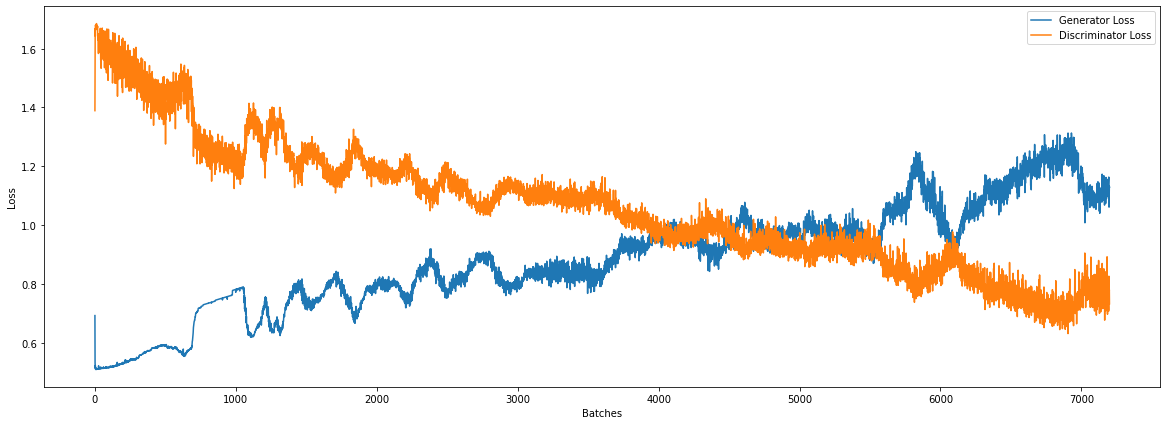

Time for epoch 360 is 2.8891451358795166 sec
Time for epoch 361 is 2.694283962249756 sec
Time for epoch 362 is 2.685330867767334 sec
Time for epoch 363 is 2.6840310096740723 sec
Time for epoch 364 is 2.6879491806030273 sec
Time for epoch 365 is 2.685753345489502 sec
Time for epoch 366 is 2.683253288269043 sec
Time for epoch 367 is 2.6837551593780518 sec
Time for epoch 368 is 2.6940886974334717 sec
Time for epoch 369 is 2.6832242012023926 sec
Time for epoch 370 is 2.702575922012329 sec
Time for epoch 371 is 2.690971612930298 sec
Time for epoch 372 is 2.693009853363037 sec
Time for epoch 373 is 2.684931516647339 sec
Time for epoch 374 is 2.7006900310516357 sec


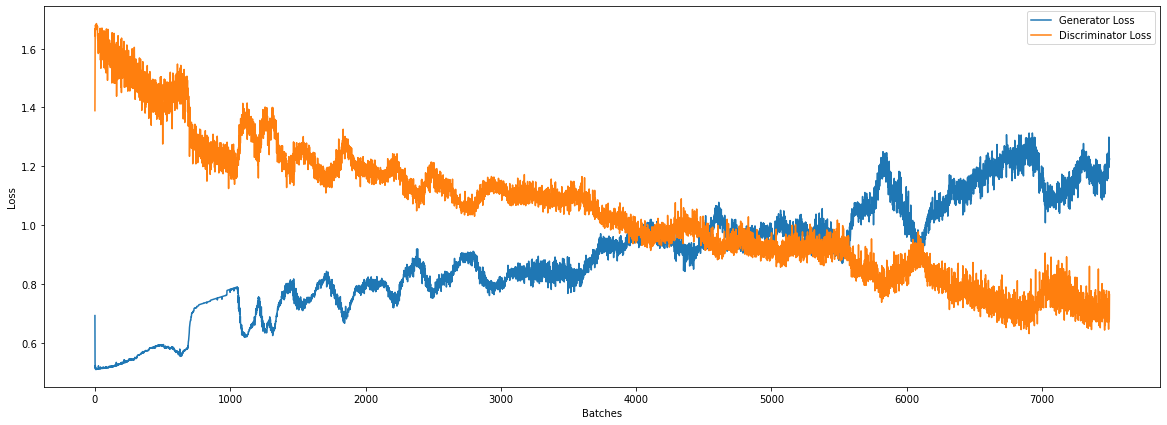

Time for epoch 375 is 2.8816959857940674 sec
Time for epoch 376 is 2.698690891265869 sec
Time for epoch 377 is 2.683523654937744 sec
Time for epoch 378 is 2.6847968101501465 sec
Time for epoch 379 is 2.6890838146209717 sec
Time for epoch 380 is 2.677034378051758 sec
Time for epoch 381 is 2.6967155933380127 sec
Time for epoch 382 is 2.683950901031494 sec
Time for epoch 383 is 2.6921379566192627 sec
Time for epoch 384 is 2.699117660522461 sec
Time for epoch 385 is 2.6955888271331787 sec
Time for epoch 386 is 2.7009782791137695 sec
Time for epoch 387 is 2.681384325027466 sec
Time for epoch 388 is 2.6859140396118164 sec
Time for epoch 389 is 2.6959407329559326 sec


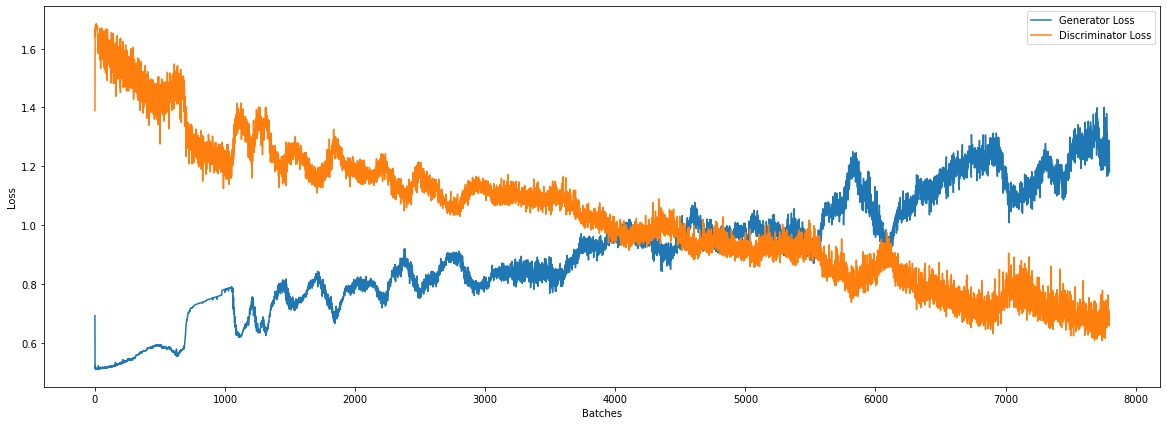

Time for epoch 390 is 2.8943374156951904 sec
Time for epoch 391 is 2.6936936378479004 sec
Time for epoch 392 is 2.6805853843688965 sec
Time for epoch 393 is 2.690286636352539 sec
Time for epoch 394 is 2.698338508605957 sec
Time for epoch 395 is 2.686184883117676 sec
Time for epoch 396 is 2.6795144081115723 sec
Time for epoch 397 is 2.691005229949951 sec
Time for epoch 398 is 2.6854522228240967 sec
Time for epoch 399 is 2.698302745819092 sec
Time for epoch 400 is 2.690436363220215 sec
Time for epoch 401 is 2.69050669670105 sec
Time for epoch 402 is 2.691411256790161 sec
Time for epoch 403 is 2.6898789405822754 sec
Time for epoch 404 is 2.707306385040283 sec


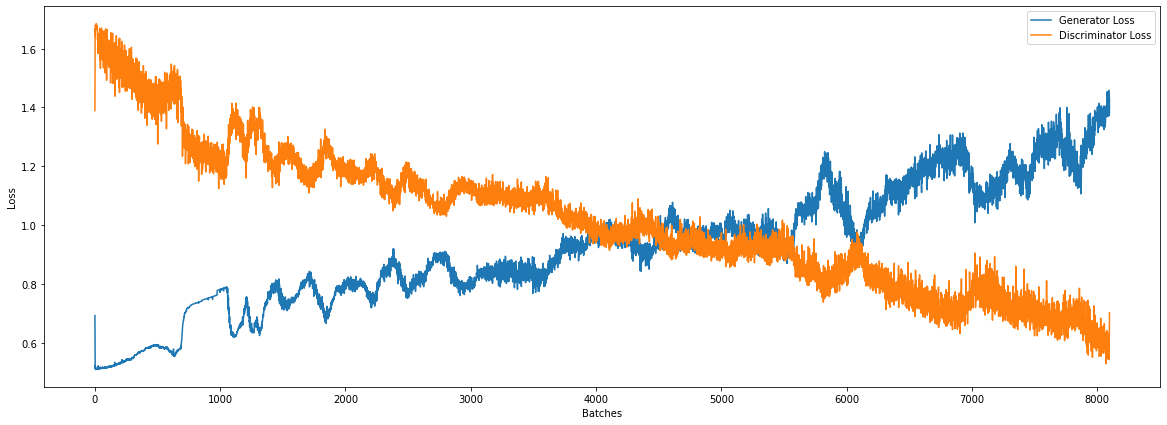

Time for epoch 405 is 2.9296672344207764 sec
Time for epoch 406 is 2.697679042816162 sec
Time for epoch 407 is 2.695840358734131 sec
Time for epoch 408 is 2.6994032859802246 sec
Time for epoch 409 is 2.684607744216919 sec
Time for epoch 410 is 2.6852190494537354 sec
Time for epoch 411 is 2.687826633453369 sec
Time for epoch 412 is 2.688824415206909 sec
Time for epoch 413 is 2.6959879398345947 sec
Time for epoch 414 is 2.720867156982422 sec
Time for epoch 415 is 2.7023918628692627 sec
Time for epoch 416 is 2.69718861579895 sec
Time for epoch 417 is 2.7076265811920166 sec
Time for epoch 418 is 2.7091922760009766 sec
Time for epoch 419 is 2.700774908065796 sec


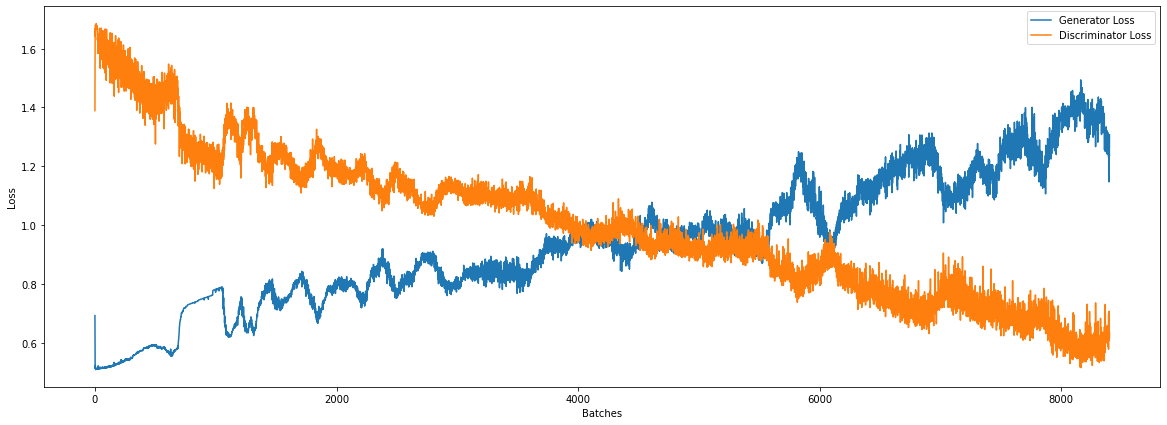

Time for epoch 420 is 2.9034669399261475 sec
Time for epoch 421 is 2.6930813789367676 sec
Time for epoch 422 is 2.700190305709839 sec
Time for epoch 423 is 2.6978983879089355 sec
Time for epoch 424 is 2.6909666061401367 sec
Time for epoch 425 is 2.6852431297302246 sec
Time for epoch 426 is 2.695493459701538 sec
Time for epoch 427 is 2.6892292499542236 sec
Time for epoch 428 is 2.700960636138916 sec
Time for epoch 429 is 2.687918186187744 sec
Time for epoch 430 is 2.685262441635132 sec
Time for epoch 431 is 2.6924023628234863 sec
Time for epoch 432 is 2.690476179122925 sec
Time for epoch 433 is 2.7025306224823 sec
Time for epoch 434 is 2.6898348331451416 sec


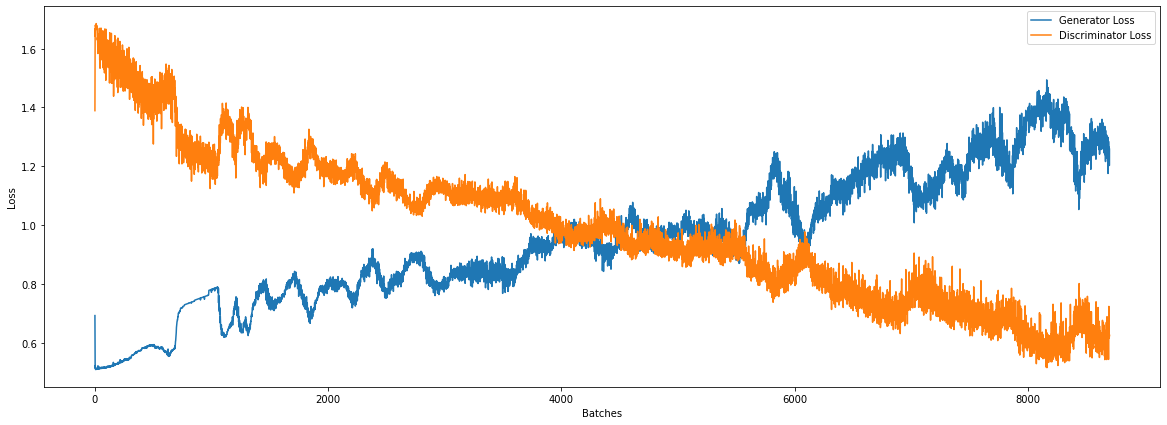

Time for epoch 435 is 2.8988864421844482 sec
Time for epoch 436 is 2.695303201675415 sec
Time for epoch 437 is 2.6997194290161133 sec
Time for epoch 438 is 2.688307285308838 sec
Time for epoch 439 is 2.693732261657715 sec
Time for epoch 440 is 2.69740629196167 sec
Time for epoch 441 is 2.6817429065704346 sec
Time for epoch 442 is 2.6909754276275635 sec
Time for epoch 443 is 2.6811063289642334 sec
Time for epoch 444 is 2.6865556240081787 sec
Time for epoch 445 is 2.6859230995178223 sec
Time for epoch 446 is 2.687993288040161 sec
Time for epoch 447 is 2.684279680252075 sec
Time for epoch 448 is 2.6908576488494873 sec
Time for epoch 449 is 2.6924402713775635 sec


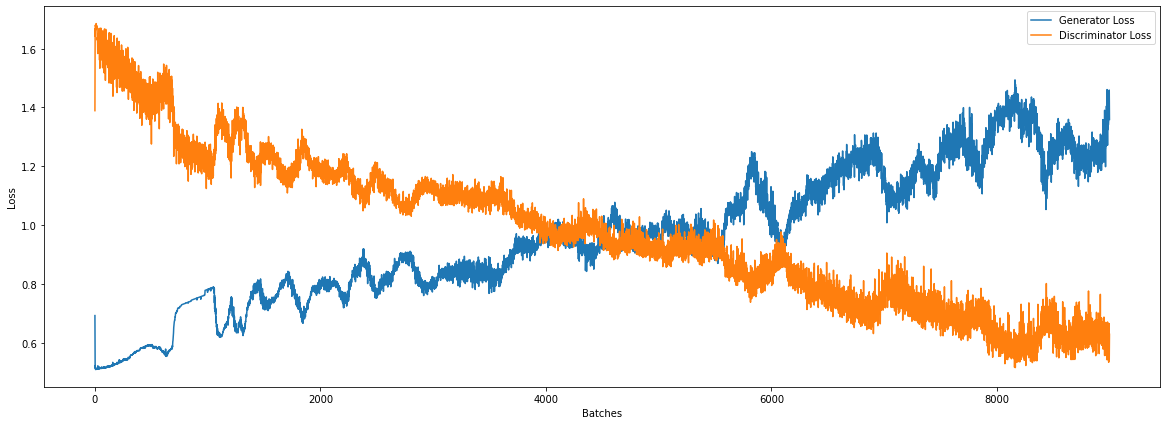

Time for epoch 450 is 2.892472267150879 sec
Time for epoch 451 is 2.6891140937805176 sec
Time for epoch 452 is 2.6913304328918457 sec
Time for epoch 453 is 2.691866159439087 sec
Time for epoch 454 is 2.694342613220215 sec
Time for epoch 455 is 2.6822733879089355 sec
Time for epoch 456 is 2.6811277866363525 sec
Time for epoch 457 is 2.6916956901550293 sec
Time for epoch 458 is 2.6867525577545166 sec
Time for epoch 459 is 2.69545578956604 sec
Time for epoch 460 is 2.6979992389678955 sec
Time for epoch 461 is 2.6921939849853516 sec
Time for epoch 462 is 2.709139585494995 sec
Time for epoch 463 is 2.6886186599731445 sec
Time for epoch 464 is 2.690840005874634 sec


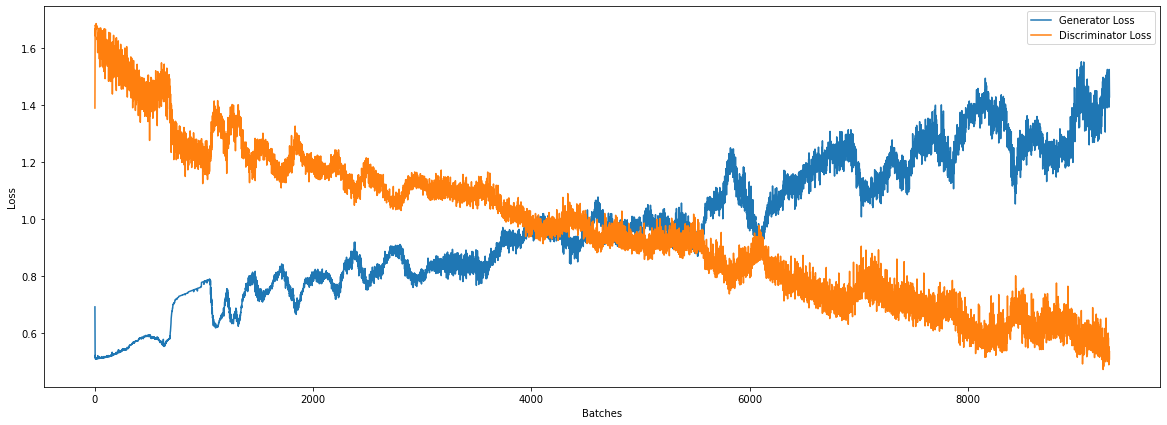

Time for epoch 465 is 2.892770528793335 sec
Time for epoch 466 is 2.6952297687530518 sec
Time for epoch 467 is 2.7052266597747803 sec
Time for epoch 468 is 2.6940090656280518 sec
Time for epoch 469 is 2.706085443496704 sec
Time for epoch 470 is 2.6828980445861816 sec
Time for epoch 471 is 2.6941897869110107 sec
Time for epoch 472 is 2.706728935241699 sec
Time for epoch 473 is 2.69071102142334 sec
Time for epoch 474 is 2.705803155899048 sec
Time for epoch 475 is 2.687295436859131 sec
Time for epoch 476 is 2.708766460418701 sec
Time for epoch 477 is 2.6885814666748047 sec
Time for epoch 478 is 2.6844913959503174 sec
Time for epoch 479 is 2.6942689418792725 sec


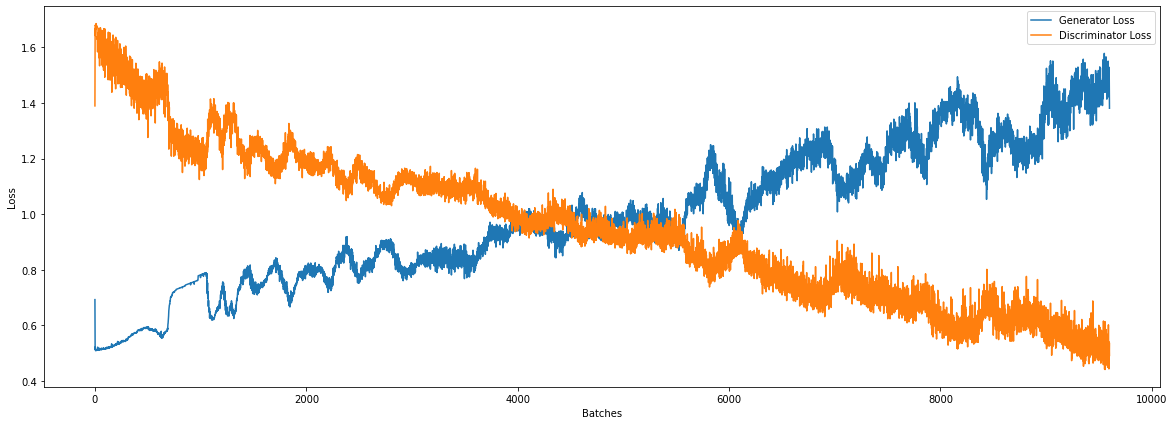

Time for epoch 480 is 2.9158008098602295 sec
Time for epoch 481 is 2.6936874389648438 sec
Time for epoch 482 is 2.689964532852173 sec
Time for epoch 483 is 2.6881906986236572 sec
Time for epoch 484 is 2.707632064819336 sec
Time for epoch 485 is 2.694307804107666 sec
Time for epoch 486 is 2.6923677921295166 sec
Time for epoch 487 is 2.6864094734191895 sec
Time for epoch 488 is 2.6851115226745605 sec
Time for epoch 489 is 2.692905902862549 sec
Time for epoch 490 is 2.685955762863159 sec
Time for epoch 491 is 2.6977386474609375 sec
Time for epoch 492 is 2.6971170902252197 sec
Time for epoch 493 is 5.168454647064209 sec
Time for epoch 494 is 2.705786943435669 sec


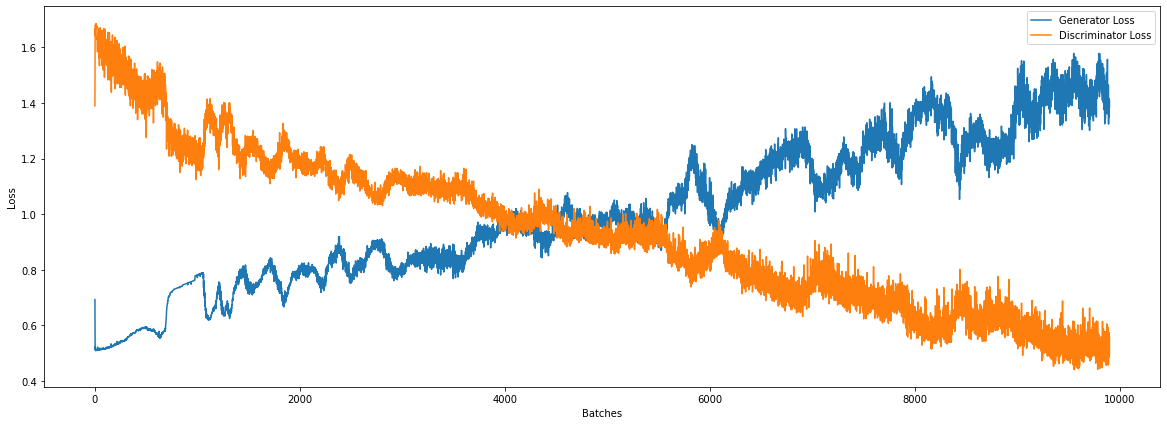

Time for epoch 495 is 2.9037489891052246 sec
Time for epoch 496 is 2.693464756011963 sec
Time for epoch 497 is 2.6969008445739746 sec
Time for epoch 498 is 2.686887502670288 sec
Time for epoch 499 is 2.6803171634674072 sec
Time for epoch 500 is 2.685447931289673 sec
Time for epoch 501 is 2.6927125453948975 sec
Time for epoch 502 is 2.6927530765533447 sec
Time for epoch 503 is 2.6869614124298096 sec
Time for epoch 504 is 2.6818130016326904 sec
Time for epoch 505 is 2.7006492614746094 sec
Time for epoch 506 is 2.691348075866699 sec
Time for epoch 507 is 2.690476179122925 sec
Time for epoch 508 is 2.687812089920044 sec
Time for epoch 509 is 2.703305959701538 sec


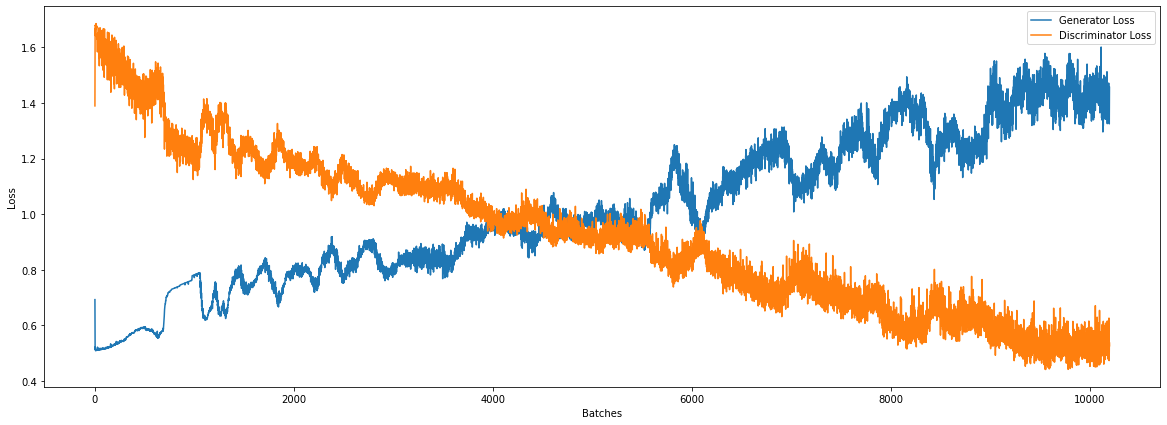

Time for epoch 510 is 2.9174768924713135 sec
Time for epoch 511 is 2.6894919872283936 sec
Time for epoch 512 is 2.687800645828247 sec
Time for epoch 513 is 2.686690092086792 sec
Time for epoch 514 is 2.6969854831695557 sec
Time for epoch 515 is 2.6899876594543457 sec
Time for epoch 516 is 2.699756383895874 sec
Time for epoch 517 is 2.6949286460876465 sec
Time for epoch 518 is 5.172962427139282 sec
Time for epoch 519 is 2.714733839035034 sec
Time for epoch 520 is 2.6866207122802734 sec
Time for epoch 521 is 2.697122812271118 sec
Time for epoch 522 is 2.6917028427124023 sec
Time for epoch 523 is 2.690385580062866 sec
Time for epoch 524 is 2.686760902404785 sec


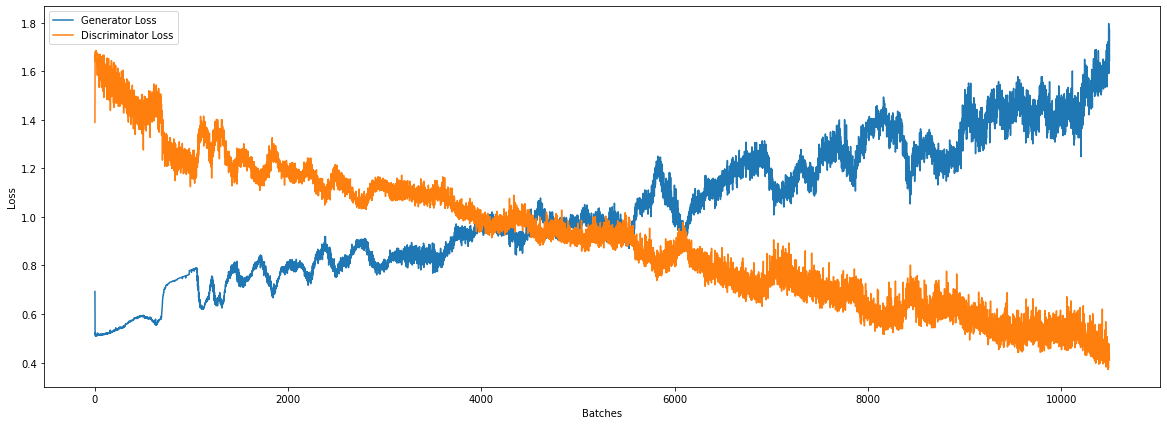

Time for epoch 525 is 3.1303839683532715 sec
Time for epoch 526 is 2.692556142807007 sec
Time for epoch 527 is 2.6776928901672363 sec
Time for epoch 528 is 2.701420783996582 sec
Time for epoch 529 is 2.688319206237793 sec
Time for epoch 530 is 2.6983933448791504 sec
Time for epoch 531 is 2.6817212104797363 sec
Time for epoch 532 is 2.6857552528381348 sec
Time for epoch 533 is 2.6819581985473633 sec
Time for epoch 534 is 2.6796765327453613 sec
Time for epoch 535 is 2.673610210418701 sec
Time for epoch 536 is 2.685511350631714 sec
Time for epoch 537 is 2.6892917156219482 sec
Time for epoch 538 is 2.693186044692993 sec
Time for epoch 539 is 2.68918514251709 sec


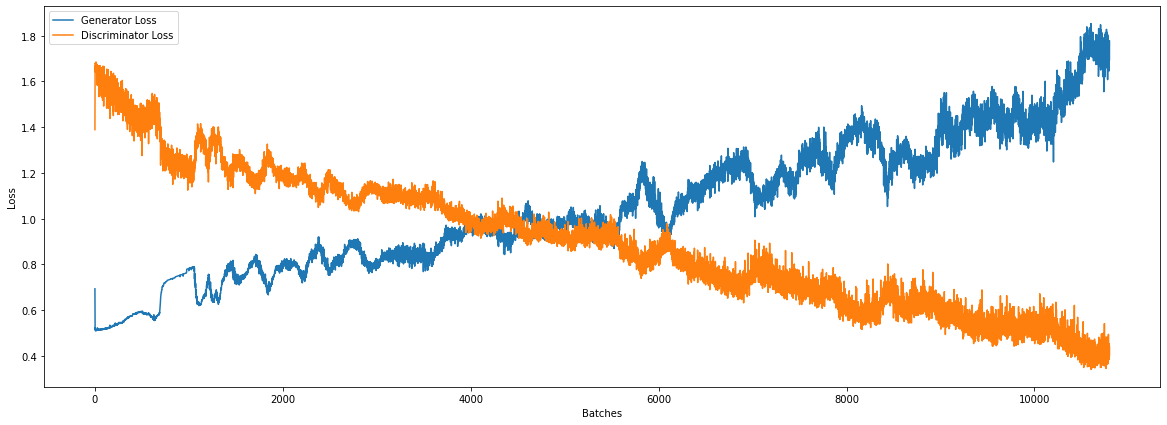

Time for epoch 540 is 2.9161627292633057 sec
Time for epoch 541 is 2.688645839691162 sec
Time for epoch 542 is 2.681835412979126 sec
Time for epoch 543 is 2.691556453704834 sec
Time for epoch 544 is 2.6882336139678955 sec
Time for epoch 545 is 2.6907894611358643 sec
Time for epoch 546 is 2.684502124786377 sec
Time for epoch 547 is 2.694627046585083 sec
Time for epoch 548 is 2.7025887966156006 sec
Time for epoch 549 is 2.697483539581299 sec
Time for epoch 550 is 2.696965456008911 sec
Time for epoch 551 is 2.693333864212036 sec
Time for epoch 552 is 2.690391778945923 sec
Time for epoch 553 is 2.6942665576934814 sec
Time for epoch 554 is 2.695385217666626 sec


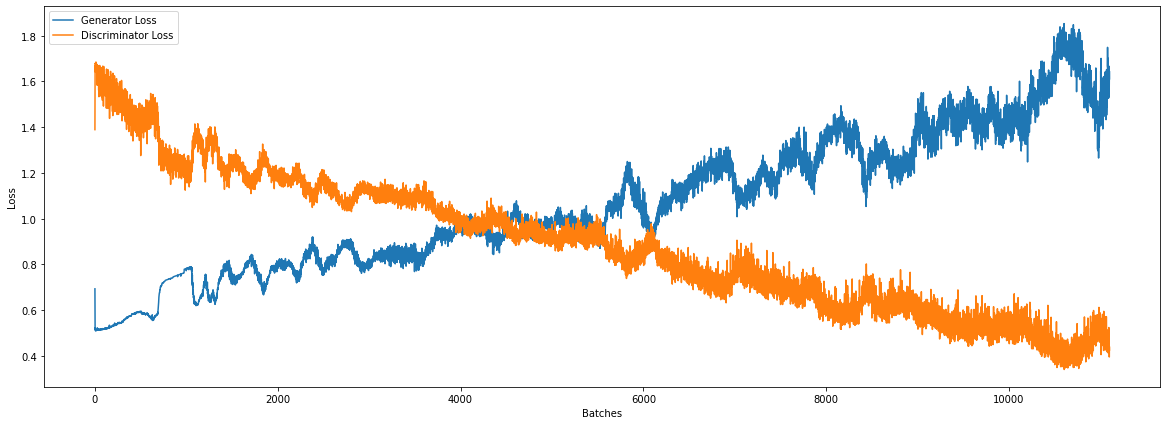

Time for epoch 555 is 2.9175145626068115 sec
Time for epoch 556 is 2.7004034519195557 sec
Time for epoch 557 is 2.69001841545105 sec
Time for epoch 558 is 2.6795172691345215 sec
Time for epoch 559 is 2.6804847717285156 sec
Time for epoch 560 is 2.683093309402466 sec
Time for epoch 561 is 2.6985397338867188 sec
Time for epoch 562 is 2.677760124206543 sec
Time for epoch 563 is 2.6790359020233154 sec
Time for epoch 564 is 2.6962053775787354 sec
Time for epoch 565 is 2.6872589588165283 sec
Time for epoch 566 is 2.684086561203003 sec
Time for epoch 567 is 2.6870858669281006 sec
Time for epoch 568 is 5.174124717712402 sec
Time for epoch 569 is 2.7000739574432373 sec


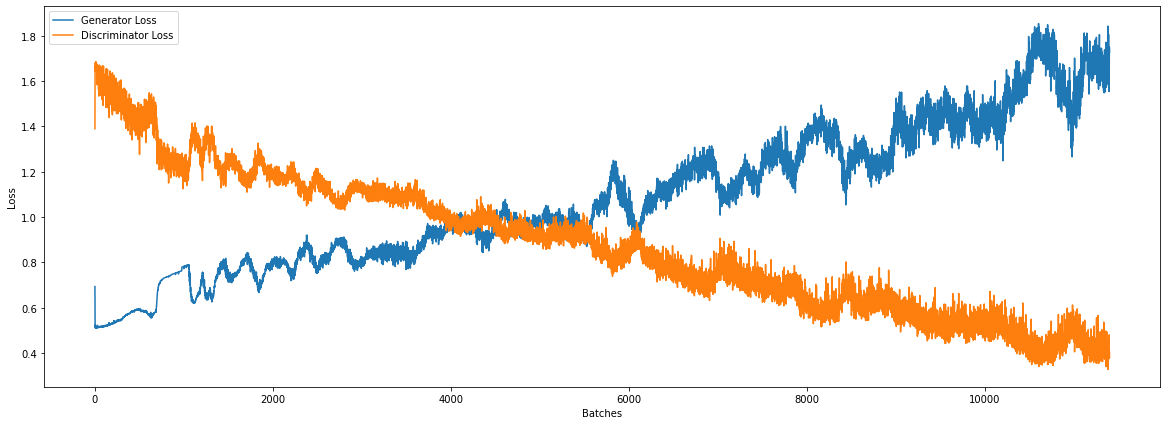

Time for epoch 570 is 2.90653657913208 sec
Time for epoch 571 is 2.7027204036712646 sec
Time for epoch 572 is 2.690049886703491 sec
Time for epoch 573 is 2.693330764770508 sec
Time for epoch 574 is 2.6785006523132324 sec
Time for epoch 575 is 2.69143009185791 sec
Time for epoch 576 is 2.6865618228912354 sec
Time for epoch 577 is 2.690622568130493 sec
Time for epoch 578 is 2.6768980026245117 sec
Time for epoch 579 is 2.6928699016571045 sec
Time for epoch 580 is 2.695362091064453 sec
Time for epoch 581 is 2.688082218170166 sec
Time for epoch 582 is 2.7071526050567627 sec
Time for epoch 583 is 2.682014226913452 sec
Time for epoch 584 is 2.68880033493042 sec


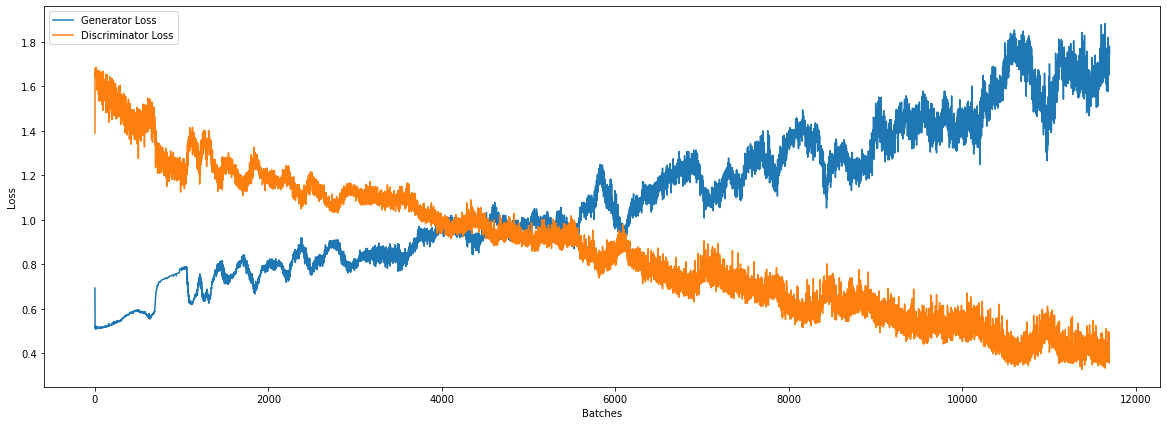

Time for epoch 585 is 2.930239200592041 sec
Time for epoch 586 is 2.6892523765563965 sec
Time for epoch 587 is 2.6901533603668213 sec
Time for epoch 588 is 2.694749355316162 sec
Time for epoch 589 is 2.679487943649292 sec
Time for epoch 590 is 2.6920740604400635 sec
Time for epoch 591 is 2.6793112754821777 sec
Time for epoch 592 is 2.692850351333618 sec
Time for epoch 593 is 2.694838047027588 sec
Time for epoch 594 is 2.7068145275115967 sec
Time for epoch 595 is 2.686035633087158 sec
Time for epoch 596 is 2.68369197845459 sec
Time for epoch 597 is 2.684136152267456 sec
Time for epoch 598 is 2.692505359649658 sec
Time for epoch 599 is 2.694002628326416 sec


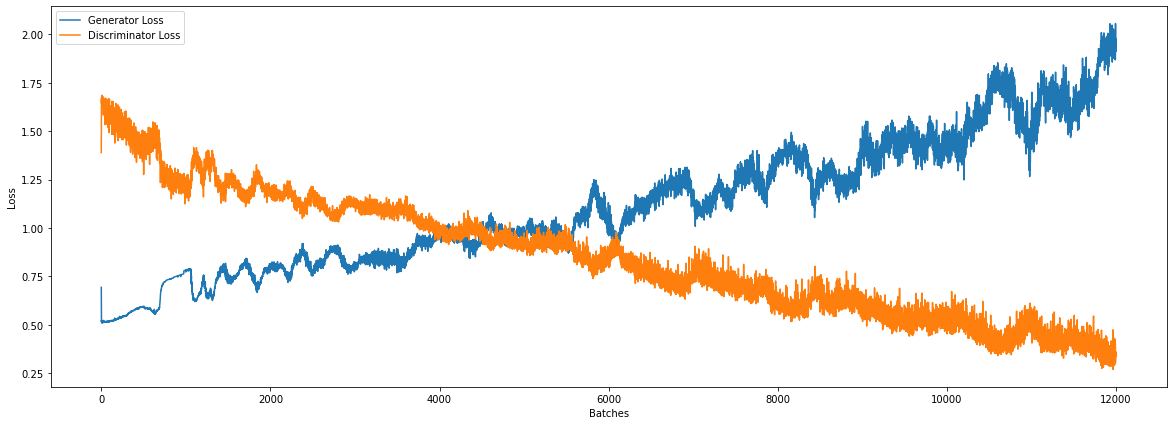

Time for epoch 600 is 2.9109933376312256 sec
Time for epoch 601 is 2.6855504512786865 sec
Time for epoch 602 is 2.688591480255127 sec
Time for epoch 603 is 2.6849827766418457 sec
Time for epoch 604 is 5.1788012981414795 sec
Time for epoch 605 is 2.70023250579834 sec
Time for epoch 606 is 2.68857741355896 sec
Time for epoch 607 is 2.686297655105591 sec
Time for epoch 608 is 2.693242311477661 sec
Time for epoch 609 is 2.6765451431274414 sec
Time for epoch 610 is 2.687822103500366 sec
Time for epoch 611 is 2.691128730773926 sec
Time for epoch 612 is 2.6918227672576904 sec
Time for epoch 613 is 2.697197437286377 sec
Time for epoch 614 is 2.6941916942596436 sec


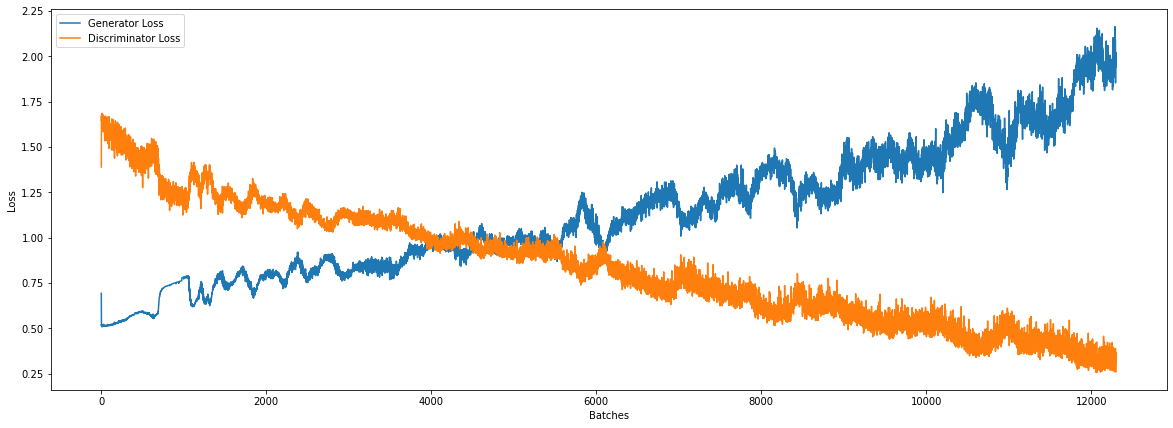

Time for epoch 615 is 2.923999786376953 sec
Time for epoch 616 is 2.6930344104766846 sec
Time for epoch 617 is 2.694406032562256 sec
Time for epoch 618 is 2.686568021774292 sec
Time for epoch 619 is 2.7152504920959473 sec
Time for epoch 620 is 2.6912903785705566 sec
Time for epoch 621 is 2.691826105117798 sec
Time for epoch 622 is 2.701216220855713 sec
Time for epoch 623 is 2.697840452194214 sec
Time for epoch 624 is 2.6923749446868896 sec
Time for epoch 625 is 2.6923654079437256 sec
Time for epoch 626 is 2.6877105236053467 sec
Time for epoch 627 is 2.6923210620880127 sec
Time for epoch 628 is 2.6817076206207275 sec
Time for epoch 629 is 2.6948916912078857 sec


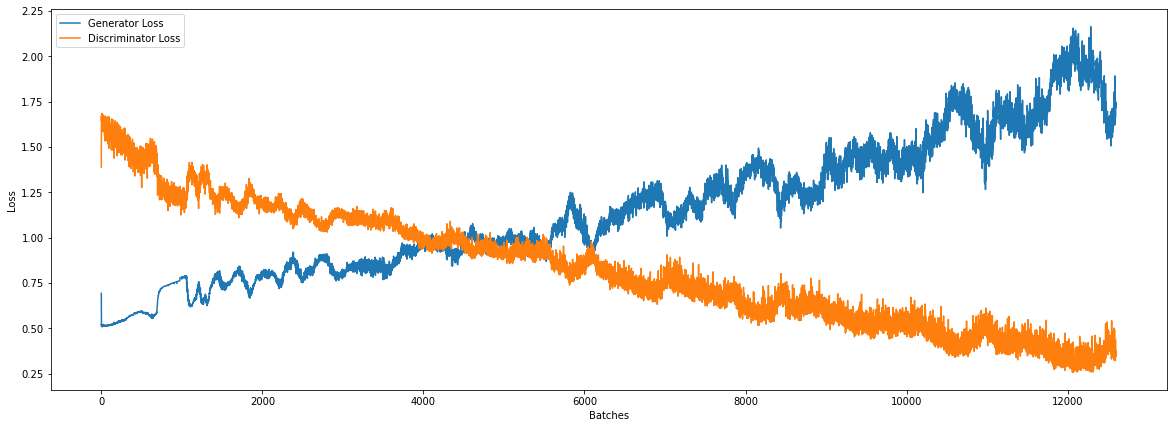

Time for epoch 630 is 2.914933443069458 sec
Time for epoch 631 is 2.692281723022461 sec
Time for epoch 632 is 2.688634157180786 sec
Time for epoch 633 is 2.6817047595977783 sec
Time for epoch 634 is 2.6827213764190674 sec
Time for epoch 635 is 2.6847541332244873 sec
Time for epoch 636 is 2.6937012672424316 sec
Time for epoch 637 is 2.6855831146240234 sec
Time for epoch 638 is 2.6947994232177734 sec
Time for epoch 639 is 2.6925253868103027 sec
Time for epoch 640 is 2.6859915256500244 sec
Time for epoch 641 is 2.7062339782714844 sec
Time for epoch 642 is 2.740154504776001 sec
Time for epoch 643 is 2.6862006187438965 sec
Time for epoch 644 is 2.683436393737793 sec


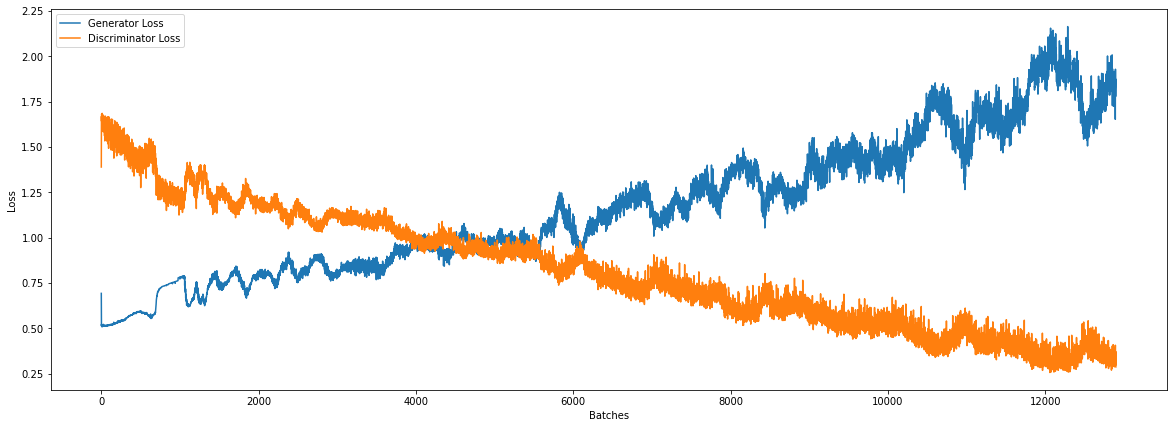

Time for epoch 645 is 2.934412717819214 sec
Time for epoch 646 is 2.694997787475586 sec
Time for epoch 647 is 5.181776762008667 sec
Time for epoch 648 is 2.7099432945251465 sec
Time for epoch 649 is 2.6873779296875 sec
Time for epoch 650 is 2.6904780864715576 sec
Time for epoch 651 is 2.6845221519470215 sec
Time for epoch 652 is 2.688668727874756 sec
Time for epoch 653 is 2.686171531677246 sec
Time for epoch 654 is 5.173068046569824 sec
Time for epoch 655 is 2.7065393924713135 sec
Time for epoch 656 is 2.6957244873046875 sec
Time for epoch 657 is 2.707775831222534 sec
Time for epoch 658 is 2.7026565074920654 sec
Time for epoch 659 is 2.6933717727661133 sec


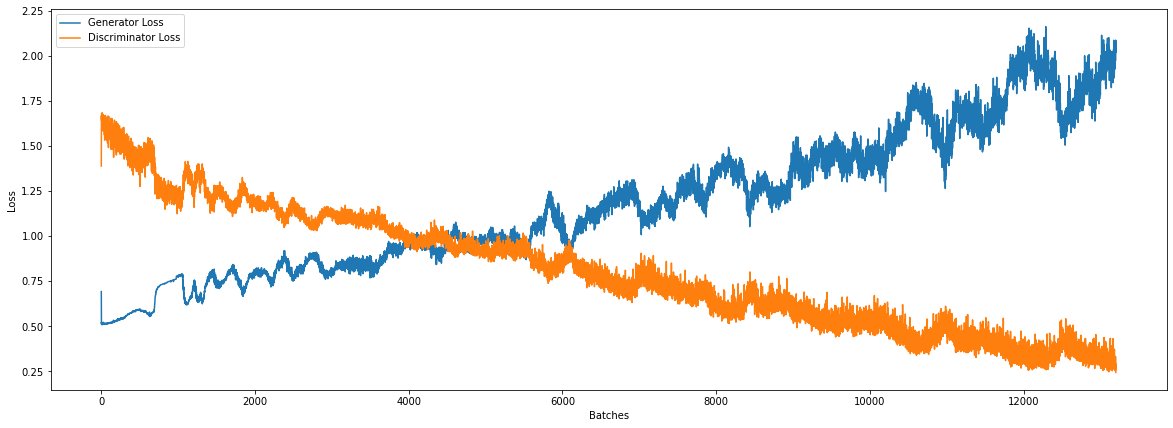

Time for epoch 660 is 2.918001890182495 sec
Time for epoch 661 is 2.7039859294891357 sec
Time for epoch 662 is 2.690486192703247 sec
Time for epoch 663 is 2.6908440589904785 sec
Time for epoch 664 is 2.687685489654541 sec
Time for epoch 665 is 2.6776463985443115 sec
Time for epoch 666 is 2.6898739337921143 sec
Time for epoch 667 is 2.688610792160034 sec
Time for epoch 668 is 2.68546986579895 sec
Time for epoch 669 is 2.684684991836548 sec
Time for epoch 670 is 2.6862175464630127 sec
Time for epoch 671 is 2.6880853176116943 sec
Time for epoch 672 is 2.699681520462036 sec
Time for epoch 673 is 2.6881144046783447 sec
Time for epoch 674 is 2.696539878845215 sec


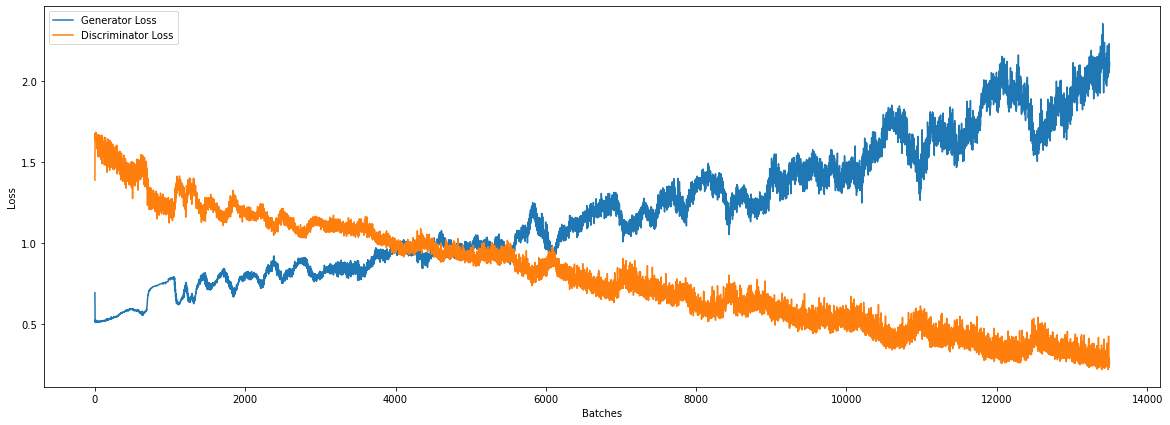

Time for epoch 675 is 2.917708396911621 sec
Time for epoch 676 is 2.690633773803711 sec
Time for epoch 677 is 2.695220470428467 sec
Time for epoch 678 is 2.6921064853668213 sec
Time for epoch 679 is 2.684994697570801 sec
Time for epoch 680 is 2.6773412227630615 sec
Time for epoch 681 is 2.696183919906616 sec
Time for epoch 682 is 2.683436632156372 sec
Time for epoch 683 is 2.684621810913086 sec
Time for epoch 684 is 2.6874942779541016 sec
Time for epoch 685 is 2.7001800537109375 sec
Time for epoch 686 is 2.6900665760040283 sec
Time for epoch 687 is 2.6860649585723877 sec
Time for epoch 688 is 2.6725423336029053 sec
Time for epoch 689 is 2.6935062408447266 sec


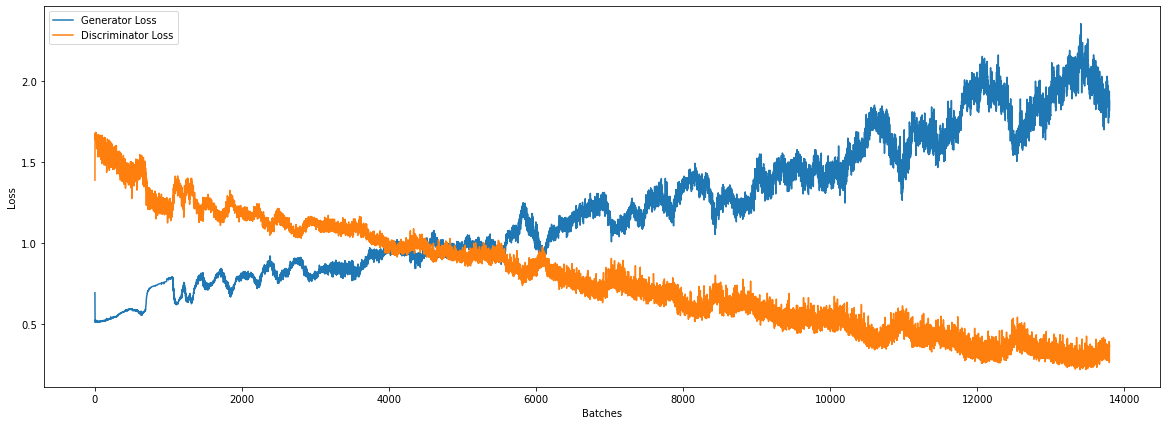

Time for epoch 690 is 2.9253597259521484 sec
Time for epoch 691 is 2.6926074028015137 sec
Time for epoch 692 is 2.6844534873962402 sec
Time for epoch 693 is 2.6950483322143555 sec
Time for epoch 694 is 2.6854422092437744 sec
Time for epoch 695 is 2.680846929550171 sec
Time for epoch 696 is 2.6784255504608154 sec
Time for epoch 697 is 2.7047717571258545 sec
Time for epoch 698 is 2.6904118061065674 sec
Time for epoch 699 is 2.6736223697662354 sec
Time for epoch 700 is 2.691645860671997 sec
Time for epoch 701 is 2.6770358085632324 sec
Time for epoch 702 is 5.178218364715576 sec
Time for epoch 703 is 2.705425977706909 sec
Time for epoch 704 is 2.6762590408325195 sec


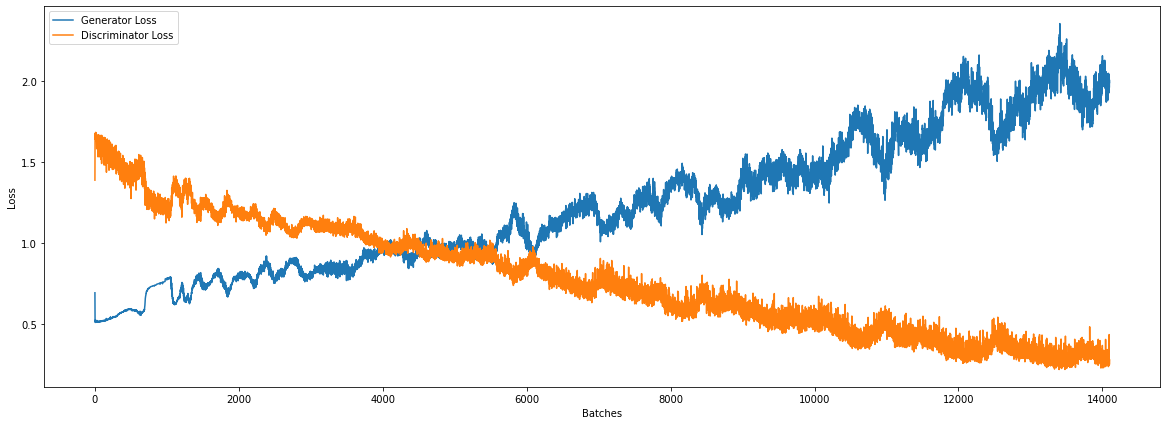

Time for epoch 705 is 2.900926113128662 sec
Time for epoch 706 is 2.688856840133667 sec
Time for epoch 707 is 2.6812195777893066 sec
Time for epoch 708 is 2.683211088180542 sec
Time for epoch 709 is 2.688486337661743 sec
Time for epoch 710 is 2.6932458877563477 sec
Time for epoch 711 is 2.675389289855957 sec
Time for epoch 712 is 2.681617021560669 sec
Time for epoch 713 is 2.684511661529541 sec
Time for epoch 714 is 2.68188214302063 sec
Time for epoch 715 is 2.690063714981079 sec
Time for epoch 716 is 2.6933250427246094 sec
Time for epoch 717 is 5.179036378860474 sec
Time for epoch 718 is 2.7083005905151367 sec
Time for epoch 719 is 2.678328514099121 sec


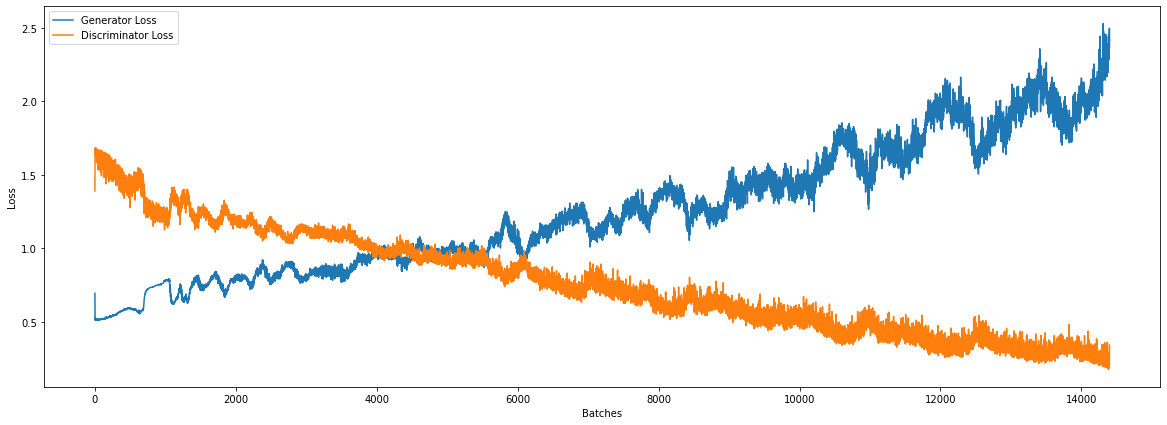

Time for epoch 720 is 2.916762590408325 sec
Time for epoch 721 is 2.681962728500366 sec
Time for epoch 722 is 2.6817209720611572 sec
Time for epoch 723 is 2.6805267333984375 sec
Time for epoch 724 is 2.6842403411865234 sec
Time for epoch 725 is 2.681464433670044 sec
Time for epoch 726 is 2.6795830726623535 sec
Time for epoch 727 is 2.686168670654297 sec
Time for epoch 728 is 2.686148166656494 sec
Time for epoch 729 is 2.6955630779266357 sec
Time for epoch 730 is 2.6811254024505615 sec
Time for epoch 731 is 2.6985065937042236 sec
Time for epoch 732 is 2.6799376010894775 sec
Time for epoch 733 is 2.6831681728363037 sec
Time for epoch 734 is 2.679567575454712 sec


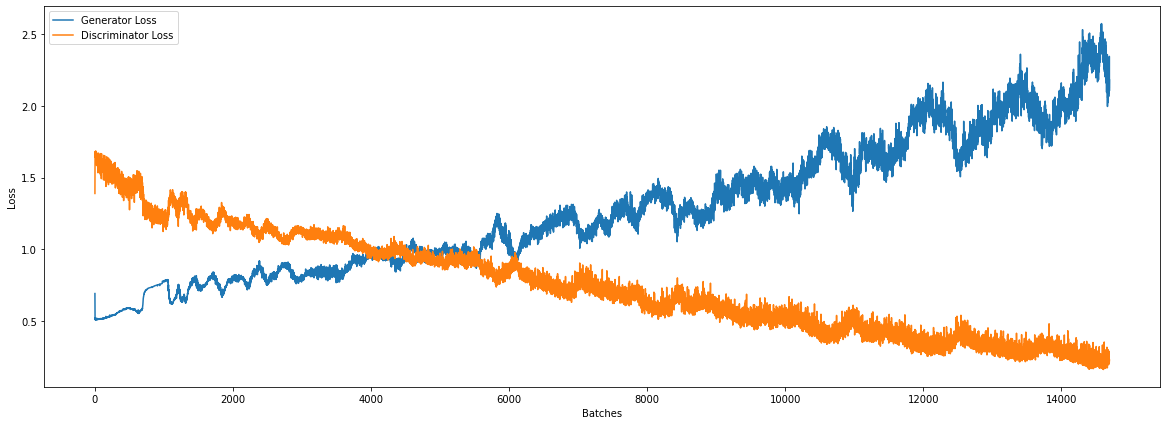

Time for epoch 735 is 2.9078750610351562 sec
Time for epoch 736 is 2.6743969917297363 sec
Time for epoch 737 is 2.6750471591949463 sec
Time for epoch 738 is 2.68131685256958 sec
Time for epoch 739 is 2.6887972354888916 sec
Time for epoch 740 is 2.6814534664154053 sec
Time for epoch 741 is 2.671095371246338 sec
Time for epoch 742 is 2.6799869537353516 sec
Time for epoch 743 is 2.6845996379852295 sec
Time for epoch 744 is 2.686647653579712 sec
Time for epoch 745 is 2.6891019344329834 sec
Time for epoch 746 is 2.6786880493164062 sec
Time for epoch 747 is 2.6934046745300293 sec
Time for epoch 748 is 2.678269624710083 sec
Time for epoch 749 is 2.6737911701202393 sec


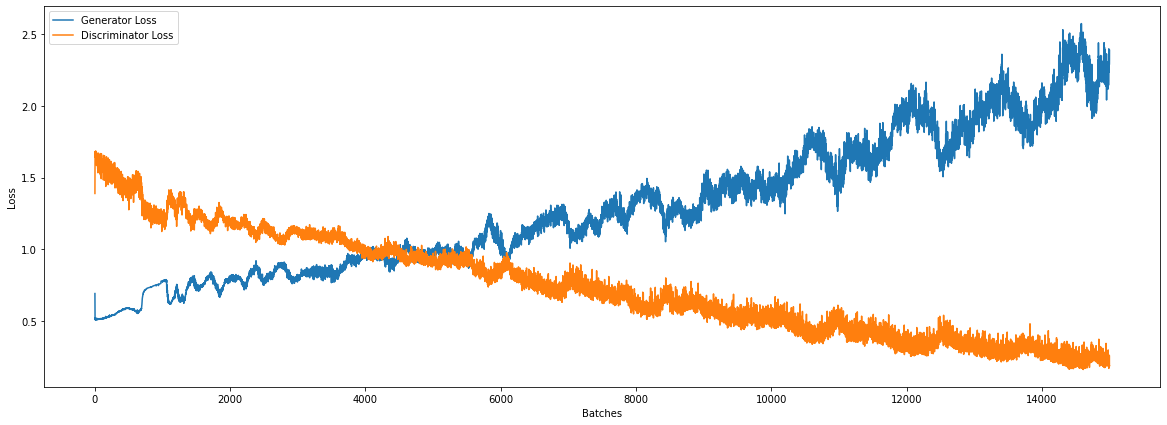

Time for epoch 750 is 2.9221105575561523 sec
Time for epoch 751 is 2.6757171154022217 sec
Time for epoch 752 is 2.685478448867798 sec
Time for epoch 753 is 2.6748993396759033 sec
Time for epoch 754 is 2.6947364807128906 sec
Time for epoch 755 is 2.6759181022644043 sec
Time for epoch 756 is 2.6752476692199707 sec
Time for epoch 757 is 2.6734836101531982 sec
Time for epoch 758 is 2.6700329780578613 sec
Time for epoch 759 is 2.6847891807556152 sec
Time for epoch 760 is 2.6831042766571045 sec
Time for epoch 761 is 2.6782209873199463 sec
Time for epoch 762 is 2.6926321983337402 sec
Time for epoch 763 is 2.681690216064453 sec
Time for epoch 764 is 2.680654287338257 sec


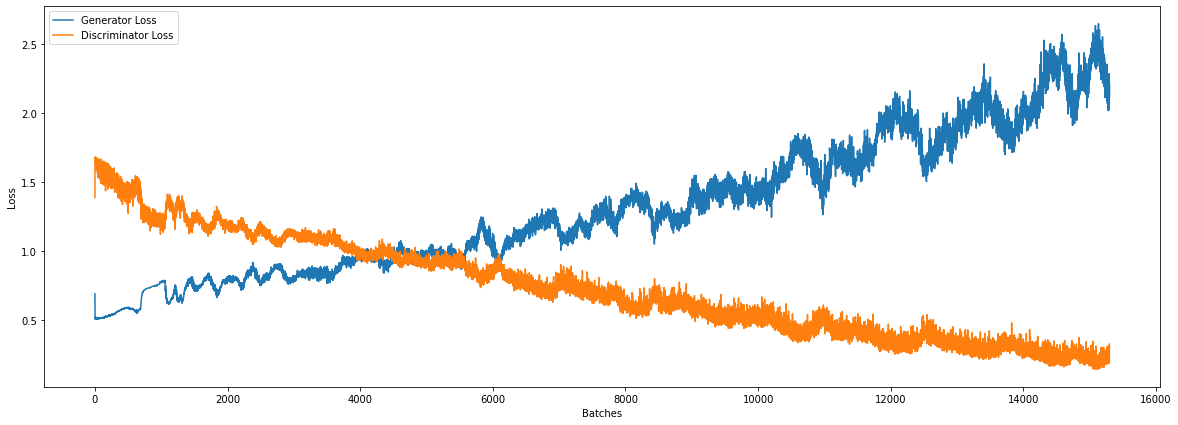

Time for epoch 765 is 2.916191577911377 sec
Time for epoch 766 is 2.68430233001709 sec
Time for epoch 767 is 2.6792454719543457 sec
Time for epoch 768 is 2.6966724395751953 sec
Time for epoch 769 is 2.6969289779663086 sec
Time for epoch 770 is 2.68465518951416 sec
Time for epoch 771 is 2.683027505874634 sec
Time for epoch 772 is 2.6883530616760254 sec
Time for epoch 773 is 2.6910922527313232 sec
Time for epoch 774 is 2.680781841278076 sec
Time for epoch 775 is 2.686281442642212 sec
Time for epoch 776 is 2.675755500793457 sec
Time for epoch 777 is 2.6934359073638916 sec
Time for epoch 778 is 2.679318428039551 sec
Time for epoch 779 is 2.684053659439087 sec


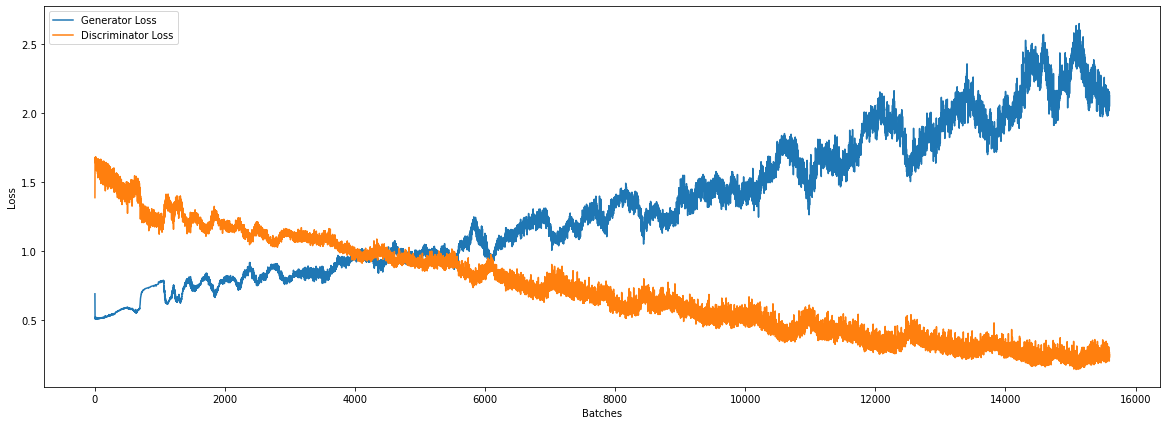

Time for epoch 780 is 2.9163310527801514 sec
Time for epoch 781 is 2.6874096393585205 sec
Time for epoch 782 is 2.6949362754821777 sec
Time for epoch 783 is 2.6803133487701416 sec
Time for epoch 784 is 2.686204195022583 sec
Time for epoch 785 is 2.6725521087646484 sec
Time for epoch 786 is 2.676758050918579 sec
Time for epoch 787 is 2.7081658840179443 sec
Time for epoch 788 is 2.675577402114868 sec
Time for epoch 789 is 5.179231882095337 sec
Time for epoch 790 is 2.704547882080078 sec
Time for epoch 791 is 2.676490545272827 sec
Time for epoch 792 is 2.6666994094848633 sec
Time for epoch 793 is 5.17321252822876 sec
Time for epoch 794 is 2.7145731449127197 sec


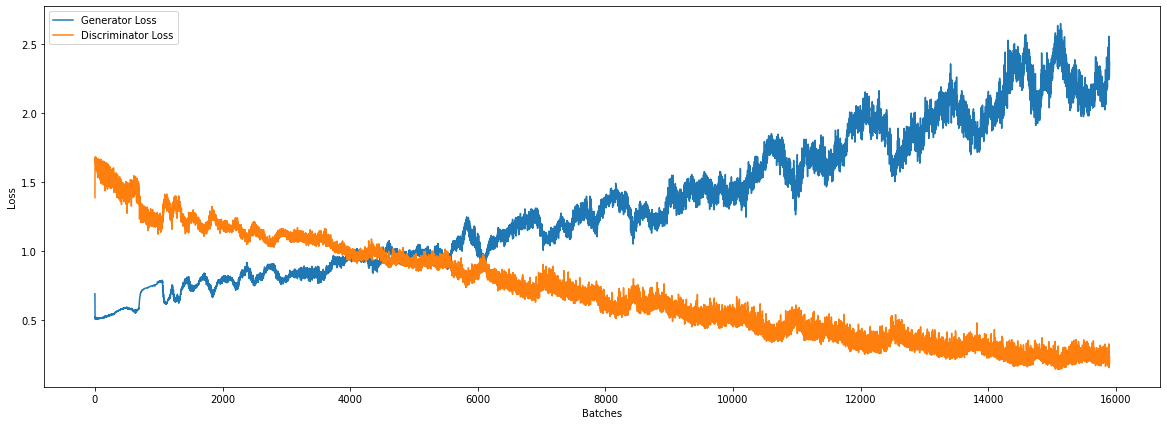

Time for epoch 795 is 2.954017400741577 sec
Time for epoch 796 is 2.698354959487915 sec
Time for epoch 797 is 2.675619602203369 sec
Time for epoch 798 is 2.6798360347747803 sec
Time for epoch 799 is 2.6737141609191895 sec
Time for epoch 800 is 2.6760270595550537 sec
Time for epoch 801 is 2.672123432159424 sec
Time for epoch 802 is 2.6785948276519775 sec
Time for epoch 803 is 2.6867666244506836 sec
Time for epoch 804 is 2.6780738830566406 sec
Time for epoch 805 is 2.684502124786377 sec
Time for epoch 806 is 2.691652297973633 sec
Time for epoch 807 is 2.6898927688598633 sec
Time for epoch 808 is 2.6767783164978027 sec
Time for epoch 809 is 2.6851816177368164 sec


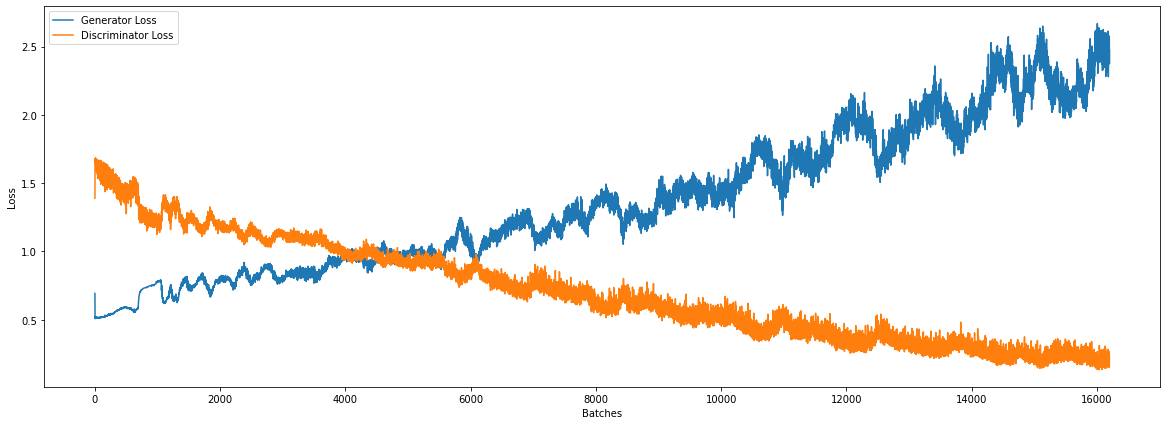

Time for epoch 810 is 2.9112133979797363 sec
Time for epoch 811 is 2.6732146739959717 sec
Time for epoch 812 is 2.6834287643432617 sec
Time for epoch 813 is 2.672031879425049 sec
Time for epoch 814 is 2.682405471801758 sec
Time for epoch 815 is 5.166458368301392 sec
Time for epoch 816 is 2.7119410037994385 sec
Time for epoch 817 is 2.67785382270813 sec
Time for epoch 818 is 2.688671112060547 sec
Time for epoch 819 is 2.6702094078063965 sec
Time for epoch 820 is 2.67745304107666 sec
Time for epoch 821 is 2.6824162006378174 sec
Time for epoch 822 is 2.6823747158050537 sec
Time for epoch 823 is 2.678443431854248 sec
Time for epoch 824 is 2.672435998916626 sec


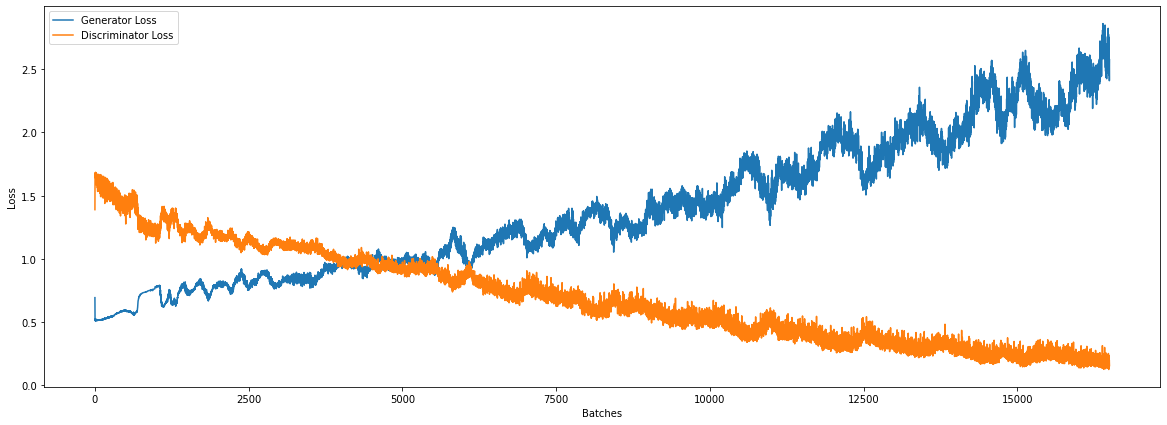

Time for epoch 825 is 2.925112724304199 sec
Time for epoch 826 is 2.686692476272583 sec
Time for epoch 827 is 2.686195135116577 sec
Time for epoch 828 is 2.683539628982544 sec
Time for epoch 829 is 2.685333490371704 sec
Time for epoch 830 is 2.6889336109161377 sec
Time for epoch 831 is 2.6728618144989014 sec
Time for epoch 832 is 2.6964638233184814 sec
Time for epoch 833 is 2.6998653411865234 sec
Time for epoch 834 is 2.678318977355957 sec
Time for epoch 835 is 2.685734987258911 sec
Time for epoch 836 is 2.6788132190704346 sec
Time for epoch 837 is 2.685250997543335 sec
Time for epoch 838 is 2.675029993057251 sec
Time for epoch 839 is 2.689131021499634 sec


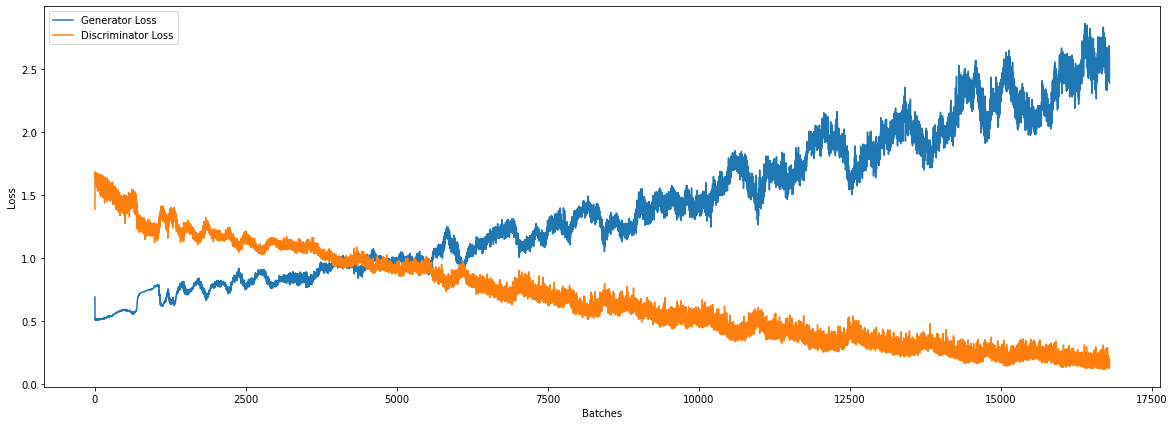

Time for epoch 840 is 2.9302871227264404 sec
Time for epoch 841 is 2.7026665210723877 sec
Time for epoch 842 is 2.6789755821228027 sec
Time for epoch 843 is 2.682730197906494 sec
Time for epoch 844 is 2.688485860824585 sec
Time for epoch 845 is 2.6762096881866455 sec
Time for epoch 846 is 2.679347276687622 sec
Time for epoch 847 is 2.6777589321136475 sec
Time for epoch 848 is 2.682765483856201 sec
Time for epoch 849 is 2.6787288188934326 sec
Time for epoch 850 is 2.6732852458953857 sec
Time for epoch 851 is 2.6844239234924316 sec
Time for epoch 852 is 2.682821750640869 sec
Time for epoch 853 is 2.6813154220581055 sec
Time for epoch 854 is 2.6751387119293213 sec


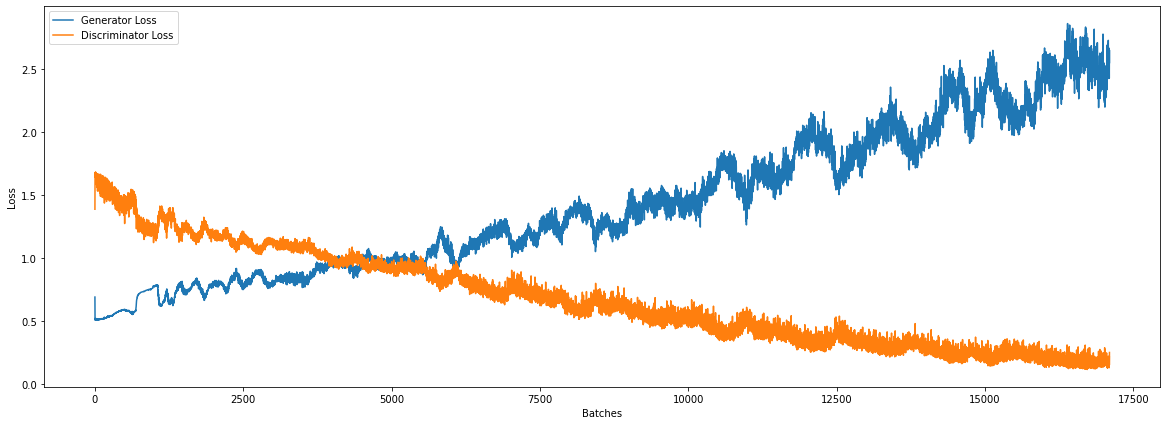

Time for epoch 855 is 2.924637794494629 sec
Time for epoch 856 is 2.706160068511963 sec
Time for epoch 857 is 2.6820192337036133 sec
Time for epoch 858 is 5.170112133026123 sec
Time for epoch 859 is 2.7014715671539307 sec
Time for epoch 860 is 2.68753981590271 sec
Time for epoch 861 is 2.68717098236084 sec
Time for epoch 862 is 2.688807249069214 sec
Time for epoch 863 is 2.6755318641662598 sec
Time for epoch 864 is 2.680595874786377 sec
Time for epoch 865 is 2.6749322414398193 sec
Time for epoch 866 is 2.6760966777801514 sec
Time for epoch 867 is 2.670797824859619 sec
Time for epoch 868 is 2.677410364151001 sec
Time for epoch 869 is 2.670736312866211 sec


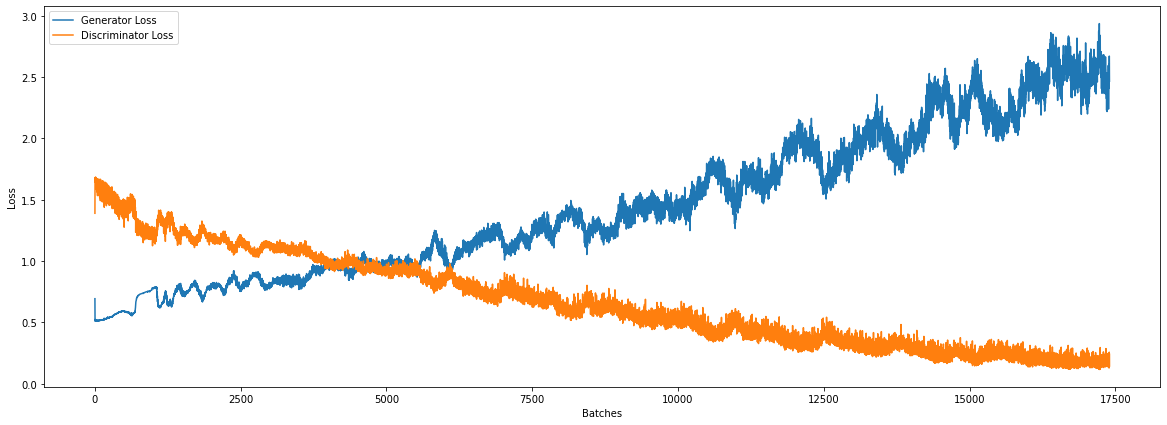

Time for epoch 870 is 2.935965061187744 sec
Time for epoch 871 is 2.683614730834961 sec
Time for epoch 872 is 2.686314344406128 sec
Time for epoch 873 is 2.673661231994629 sec
Time for epoch 874 is 2.679940938949585 sec
Time for epoch 875 is 2.687324047088623 sec
Time for epoch 876 is 2.675863265991211 sec
Time for epoch 877 is 2.684370279312134 sec
Time for epoch 878 is 2.6900579929351807 sec
Time for epoch 879 is 2.683713436126709 sec
Time for epoch 880 is 2.6902120113372803 sec
Time for epoch 881 is 2.6809005737304688 sec
Time for epoch 882 is 2.6845381259918213 sec
Time for epoch 883 is 2.67738676071167 sec
Time for epoch 884 is 2.67584228515625 sec


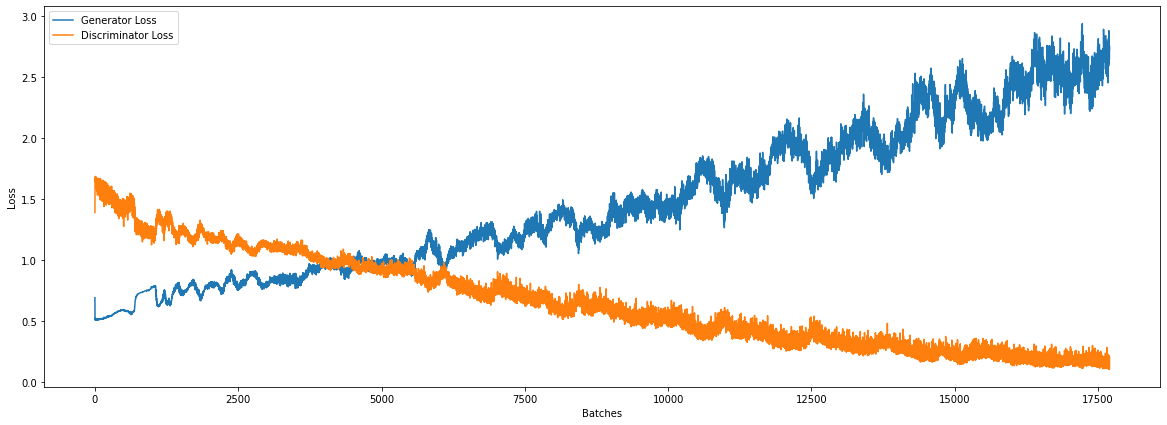

Time for epoch 885 is 2.9319570064544678 sec
Time for epoch 886 is 2.6852447986602783 sec
Time for epoch 887 is 2.678311586380005 sec
Time for epoch 888 is 2.673199415206909 sec
Time for epoch 889 is 2.685117483139038 sec
Time for epoch 890 is 2.6781113147735596 sec
Time for epoch 891 is 2.6829278469085693 sec
Time for epoch 892 is 2.6806843280792236 sec
Time for epoch 893 is 2.6913108825683594 sec
Time for epoch 894 is 2.697661876678467 sec
Time for epoch 895 is 2.684580087661743 sec
Time for epoch 896 is 2.6908535957336426 sec
Time for epoch 897 is 2.690683364868164 sec
Time for epoch 898 is 2.6989684104919434 sec
Time for epoch 899 is 2.6896820068359375 sec


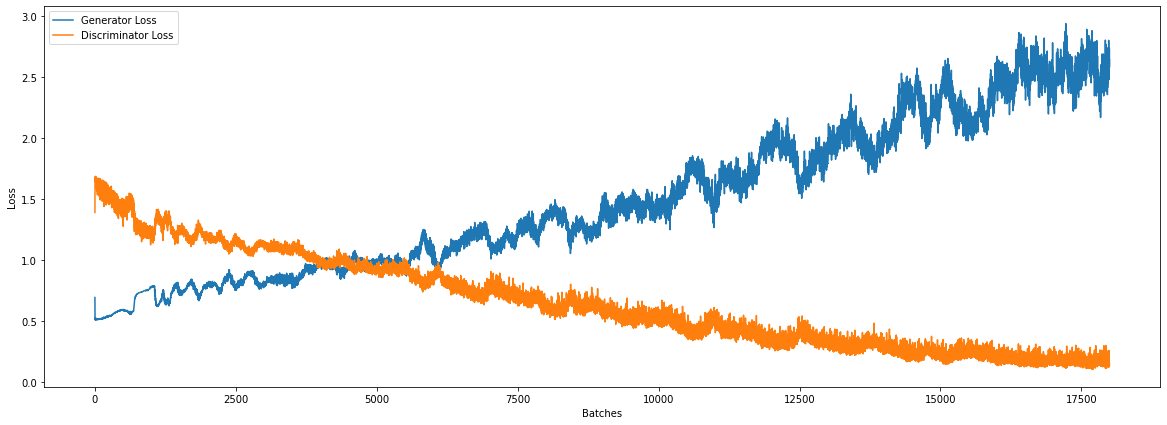

Time for epoch 900 is 2.924565076828003 sec
Time for epoch 901 is 2.683908462524414 sec
Time for epoch 902 is 2.687377691268921 sec
Time for epoch 903 is 2.6876354217529297 sec
Time for epoch 904 is 2.6883492469787598 sec
Time for epoch 905 is 2.6853201389312744 sec
Time for epoch 906 is 2.6829700469970703 sec
Time for epoch 907 is 2.681846857070923 sec
Time for epoch 908 is 2.673564910888672 sec
Time for epoch 909 is 2.6827917098999023 sec
Time for epoch 910 is 2.683793544769287 sec
Time for epoch 911 is 2.6834640502929688 sec
Time for epoch 912 is 2.6774351596832275 sec
Time for epoch 913 is 2.6871886253356934 sec
Time for epoch 914 is 2.6752099990844727 sec


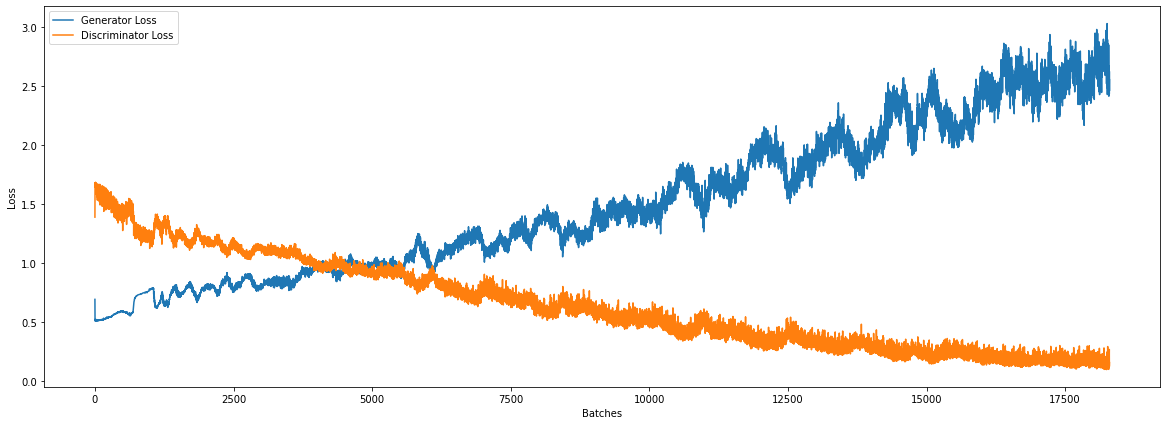

Time for epoch 915 is 2.9492733478546143 sec
Time for epoch 916 is 2.690342426300049 sec
Time for epoch 917 is 2.6777288913726807 sec
Time for epoch 918 is 2.6942830085754395 sec
Time for epoch 919 is 2.6834068298339844 sec
Time for epoch 920 is 2.6822853088378906 sec
Time for epoch 921 is 2.6784653663635254 sec
Time for epoch 922 is 2.6795947551727295 sec
Time for epoch 923 is 2.6764469146728516 sec
Time for epoch 924 is 2.686126232147217 sec
Time for epoch 925 is 2.6876797676086426 sec
Time for epoch 926 is 2.6798715591430664 sec
Time for epoch 927 is 2.684329032897949 sec
Time for epoch 928 is 2.6860404014587402 sec
Time for epoch 929 is 2.6811554431915283 sec


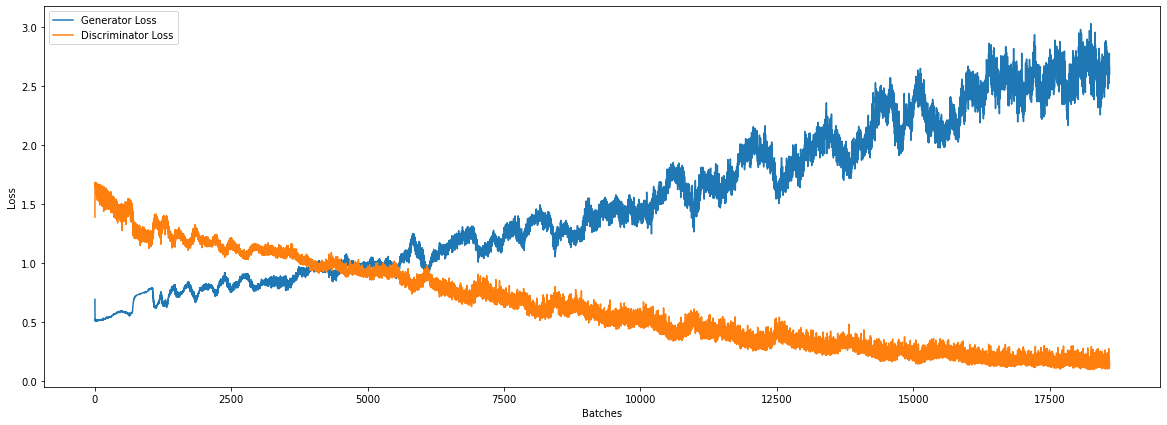

Time for epoch 930 is 2.948740005493164 sec
Time for epoch 931 is 2.687347173690796 sec
Time for epoch 932 is 2.6897952556610107 sec
Time for epoch 933 is 2.683465003967285 sec
Time for epoch 934 is 2.6786203384399414 sec
Time for epoch 935 is 5.170575380325317 sec
Time for epoch 936 is 2.715301990509033 sec
Time for epoch 937 is 2.6969637870788574 sec
Time for epoch 938 is 2.683955430984497 sec
Time for epoch 939 is 2.6786394119262695 sec
Time for epoch 940 is 2.690859794616699 sec
Time for epoch 941 is 2.6750259399414062 sec
Time for epoch 942 is 2.6851863861083984 sec
Time for epoch 943 is 2.6779603958129883 sec
Time for epoch 944 is 2.67271089553833 sec


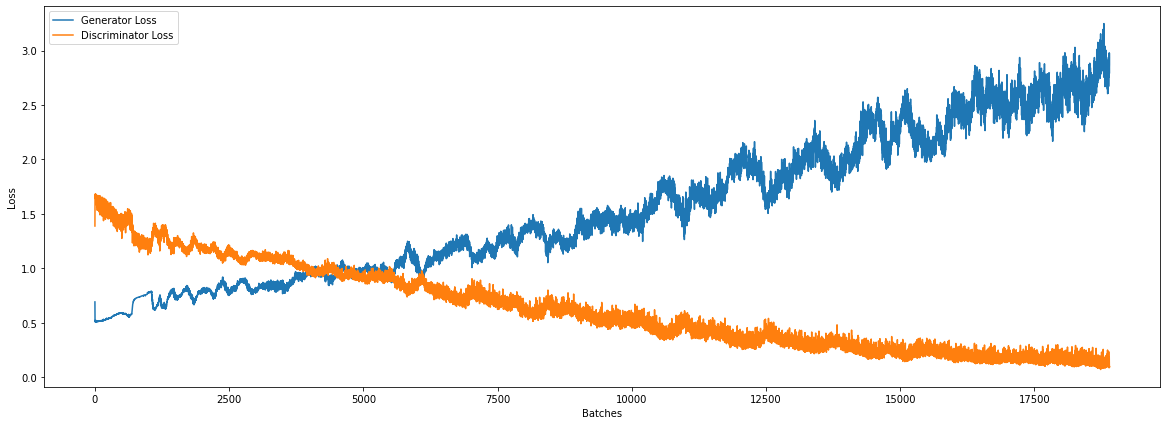

Time for epoch 945 is 2.948906660079956 sec
Time for epoch 946 is 2.695687770843506 sec
Time for epoch 947 is 2.687063217163086 sec
Time for epoch 948 is 2.6776580810546875 sec
Time for epoch 949 is 2.6864163875579834 sec
Time for epoch 950 is 2.680968999862671 sec
Time for epoch 951 is 2.679889678955078 sec
Time for epoch 952 is 2.6880075931549072 sec
Time for epoch 953 is 2.693826198577881 sec
Time for epoch 954 is 2.674267292022705 sec
Time for epoch 955 is 2.680598497390747 sec
Time for epoch 956 is 2.6772501468658447 sec
Time for epoch 957 is 2.6744322776794434 sec
Time for epoch 958 is 2.6827232837677 sec
Time for epoch 959 is 2.6786458492279053 sec


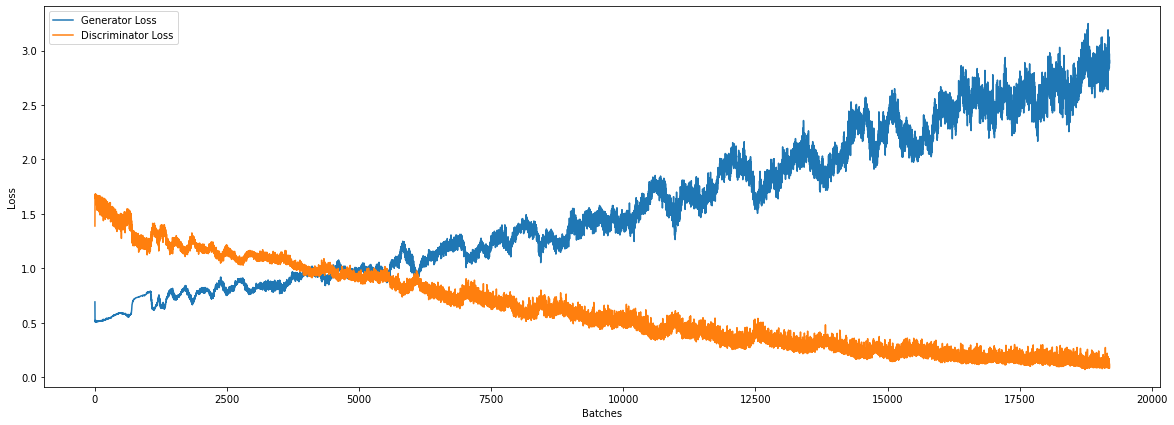

Time for epoch 960 is 2.9486794471740723 sec
Time for epoch 961 is 2.6890017986297607 sec
Time for epoch 962 is 2.6937689781188965 sec
Time for epoch 963 is 2.680530071258545 sec
Time for epoch 964 is 2.6722123622894287 sec
Time for epoch 965 is 2.6937341690063477 sec
Time for epoch 966 is 2.669328212738037 sec
Time for epoch 967 is 2.6739730834960938 sec
Time for epoch 968 is 2.677596092224121 sec
Time for epoch 969 is 2.6969754695892334 sec
Time for epoch 970 is 2.6719930171966553 sec
Time for epoch 971 is 2.682570695877075 sec
Time for epoch 972 is 2.6840004920959473 sec
Time for epoch 973 is 2.678717851638794 sec
Time for epoch 974 is 2.6809022426605225 sec


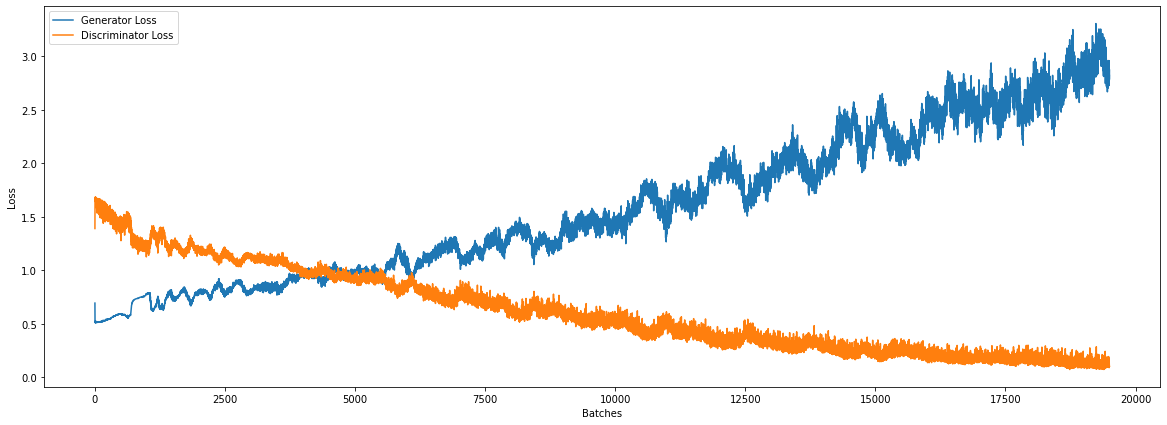

Time for epoch 975 is 2.9403326511383057 sec
Time for epoch 976 is 2.685309410095215 sec
Time for epoch 977 is 2.6817290782928467 sec
Time for epoch 978 is 2.6900272369384766 sec
Time for epoch 979 is 2.6835947036743164 sec
Time for epoch 980 is 2.6833224296569824 sec
Time for epoch 981 is 2.6739838123321533 sec
Time for epoch 982 is 2.6774065494537354 sec
Time for epoch 983 is 2.6943576335906982 sec
Time for epoch 984 is 2.678589105606079 sec
Time for epoch 985 is 2.683647632598877 sec
Time for epoch 986 is 2.689816951751709 sec
Time for epoch 987 is 2.6828348636627197 sec
Time for epoch 988 is 2.6772780418395996 sec
Time for epoch 989 is 2.6782450675964355 sec


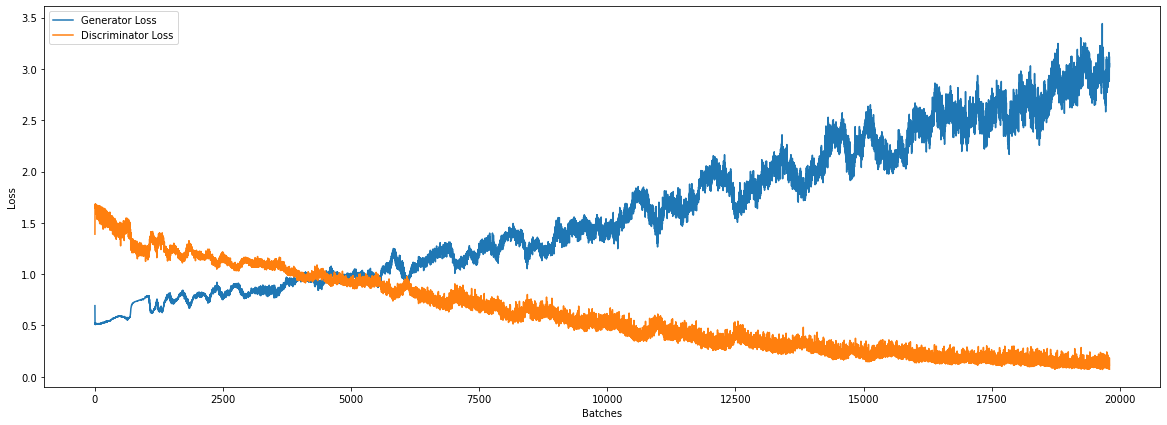

Time for epoch 990 is 3.12630558013916 sec
Time for epoch 991 is 2.685101270675659 sec
Time for epoch 992 is 2.6823995113372803 sec
Time for epoch 993 is 2.6972012519836426 sec
Time for epoch 994 is 2.685380458831787 sec
Time for epoch 995 is 2.679213762283325 sec
Time for epoch 996 is 2.684290647506714 sec
Time for epoch 997 is 2.6848974227905273 sec
Time for epoch 998 is 2.678887367248535 sec
Time for epoch 999 is 2.6835038661956787 sec
Time for epoch 1000 is 2.680046558380127 sec


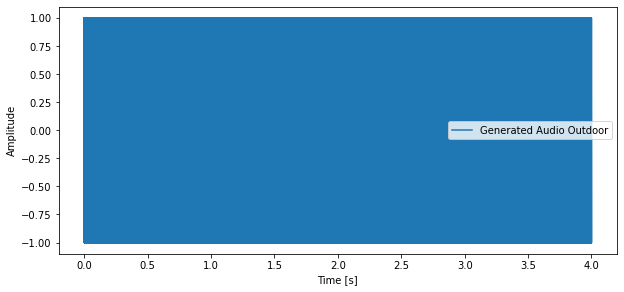

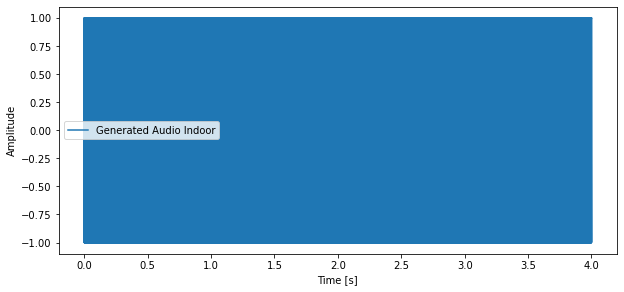

<Figure size 432x288 with 0 Axes>

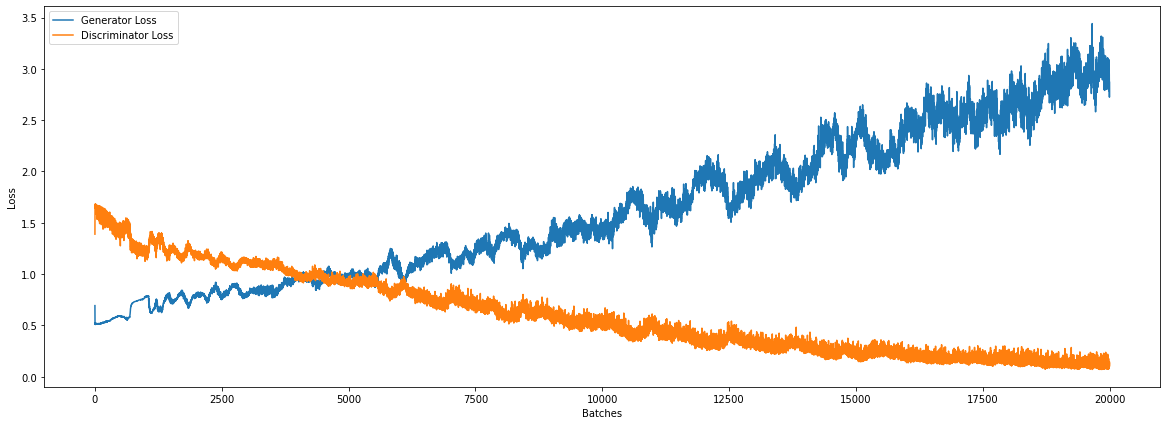

In [ ]:
BATCH_SIZE  = 10
BUFFER_SIZE = 200
LATENT_DIM  = 100
epochs      = 1000

batched_dataset = tf.data.Dataset.from_tensor_slices((dataset_norm, labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(batched_dataset, epochs, epochs_plot=False, history_plot=False)

---
---
---
---